In [ ]:
import sys
import scvi
import scanpy as sc
from inVAE import FinVAE
import scvi
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import Classifier
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import classification_report
from scarches.models.scpoli import scPoli

sc.set_figure_params(dpi=200,figsize=(6,4),fontsize=10,frameon=False)

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

## Gather results

### Results from checkpoint

In [ ]:
results_dir = "/home/icb/ferdinand.kapl/project-inpossible/outputs/transfer_labeling_selected_hp"

In [4]:
adata = sc.read_h5ad('data/heart_transfer_labeling.h5ad')
adata.var_names_make_unique()
adata.layers['counts'] = adata.layers['counts'].astype(np.float32)

adata_train = adata[adata.obs['partition'] == 'train'].copy()
adata_test = adata[adata.obs['partition'] == 'test'].copy()
adata_train_val = adata[adata.obs['partition'] != 'test'].copy()

adata_hcm = sc.read_h5ad('data/heart_hcm.h5ad')
adata_hcm.var_names_make_unique()
adata_hcm.layers['counts'] = adata_hcm.layers['counts'].astype(np.float32)

In [5]:
adata_val = adata[adata.obs['partition'] == 'val'].copy()

In [50]:
def get_model(adata_train_val, adata_train, checkpoint_path, classifier_path, label_key):
    model = FinVAE.load_model(save_path=checkpoint_path, adata=adata_train_val, device='cuda')
    
    classifier = Classifier.load(
        X = model.get_latent_representation(adata_train),
        y = adata_train.obs[label_key],
        save_path = classifier_path,
        device = 'cuda'
    )
    return model, classifier

In [51]:
def calculate_metrics(adata_pred, label_key, classifier, model, metric_name):
    y_test = adata_pred.obs[label_key]
    adata_pred.obs[label_key] = 'unknown'

    # pred_test
    pred_test = classifier.predict(model.get_latent_representation(adata_pred))

    # Acc
    test_acc = (pred_test == y_test).mean()

    # F1
    # Calculate the weighted F1 score
    weighted_f1_test = f1_score(y_test, pred_test, average='weighted')

    # Calculate the macro F1 score
    macro_f1_test = f1_score(y_test, pred_test, average='macro')

    # Result per category
    classes = sorted(set(y_test))
    f1_per_class = f1_score(y_test, pred_test, labels=classes, average=None)

    adata_pred.obs[label_key] = y_test

    return {
        f"{metric_name}_acc": test_acc, 
        f"weighted_f1_{metric_name}": weighted_f1_test, 
        f"macro_f1_{metric_name}": macro_f1_test,
        f"f1_per_class_{metric_name}": f1_per_class
    }

In [ ]:
# Initialize an empty list to store dataframes
dfs_ct = []
dfs_cond = []

# Walk through the directory
for root, dirs, files in os.walk(results_dir):
    for file in files:
        if file.endswith(".pt") and "model" in file:
            file_path = os.path.join(root, file)
            classifier_path = os.path.join(root, f"classifier_{file[6:]}")

            slurm_id = file[6:14]

            # Step 1: Navigate up two directories
            parent_dir = os.path.dirname(os.path.dirname(file_path))

            # Step 2: Extract the directory name containing hyperparameters
            dir_name = os.path.basename(parent_dir)

            # Step 3: Split the directory name into individual key=value pairs
            param_pairs = dir_name.split(',')

            # Step 4: Parse the key=value pairs into a dictionary
            hyperparams = {}
            for pair in param_pairs:
                if '=' in pair:
                    key, value = pair.split('=', 1)
                    hyperparams[key] = value
            
            model, classifier = get_model(
                adata_train_val=adata_train_val, 
                adata_train=adata_train, 
                checkpoint_path=file_path, 
                classifier_path=classifier_path, 
                label_key=hyperparams['label_key']
            )

            metrics_test = calculate_metrics(
                adata_pred=adata_test, 
                label_key=hyperparams['label_key'], 
                classifier=classifier, 
                model=model,
                metric_name="test"
            )

            metrics_unseen = calculate_metrics(
                adata_pred=adata_hcm, 
                label_key=hyperparams['label_key'], 
                classifier=classifier, 
                model=model,
                metric_name="unseen"
            )

            metrics = {**hyperparams, **metrics_test, **metrics_unseen}
            metrics.update({
                "slurm_id": slurm_id,
                "model_path": file_path,
                "class_path": classifier_path,
            })

            #metrics.update(hyperparams)
            df = pd.DataFrame(metrics, index=[0])

            if hyperparams['label_key'] == "predicted_labels":
                dfs_ct.append(df)
            elif hyperparams['label_key'] == "condition":
                dfs_cond.append(df)

# Concatenate all dataframes
cell_type_df = pd.concat(dfs_ct, ignore_index=True)
condition_df = pd.concat(dfs_cond, ignore_index=True)

In [ ]:
example_run = condition_df[condition_df['model_name_full'] == 'inVAE_mlp'].iloc[0]
model_path_tmp = example_run['model_path']
class_path_tmp = example_run['class_path']

In [91]:
final_run_ct_df = pd.concat(dfs_ct, ignore_index=True)
final_run_cond_df = pd.concat(dfs_cond, ignore_index=True)

In [102]:
final_run_cond_df.to_csv(os.path.join(results_dir, "final_run_cond_df.csv"), index=False)
final_run_ct_df.to_csv(os.path.join(results_dir, "final_run_ct_df.csv"), index=False)

In [26]:
hp_ct_df = pd.concat(dfs_ct, ignore_index=True)
hp_cond_df = pd.concat(dfs_cond, ignore_index=True)

In [35]:
# Only select runs for the second hp experiment
hp_ct_df = hp_ct_df.loc[hp_ct_df['slurm_id'].astype(int) > 27008318]

In [42]:
cell_type_df = cell_type_df.drop_duplicates()

In [48]:
merged_ct_df = pd.merge(cell_type_df, hp_ct_df, on=['batch_key', 'batch_size', 'fix_mean_prior', 'fix_var_prior', 'label_key', 'latent_dim_spur', 'learning_rate'], how='inner')
merged_cond_df = pd.merge(condition_df, hp_cond_df, on=['batch_key', 'batch_size', 'fix_mean_prior', 'fix_var_prior', 'label_key', 'latent_dim_spur', 'learning_rate'], how='inner')

In [50]:
merged_cond_df.drop(columns=["unseen_acc", "weighted_f1_unseen", "macro_f1_unseen"], inplace=True)

In [19]:
hp_exp_dir = "/home/icb/ferdinand.kapl/project-inpossible/outputs/transfer_labeling_hp_multirun"

In [52]:
#cell_type_df.to_csv(os.path.join(hp_exp_dir, "hp_cell_type_classification.csv"), index=False)
#condition_df.to_csv(os.path.join(hp_exp_dir, "hp_condition_classification.csv"), index=False)
merged_ct_df.to_csv(os.path.join(hp_exp_dir, "hp_cell_type_classification.csv"), index=False)
merged_cond_df.to_csv(os.path.join(hp_exp_dir, "hp_condition_classification.csv"), index=False)

In [ ]:
# Iterate over 10 best runs
select_val = []
best_ct = merged_ct_df.sort_values(by='macro_f1_val', ascending=False).head(10)

for idx, row in best_ct.iterrows():
    model, classifier = get_model(
        adata_train_val=adata_train_val, 
        adata_train=adata_train, 
        checkpoint_path=row['model_path'], 
        classifier_path=row['class_path'], 
        label_key='predicted_labels'
    )

    metrics_val = calculate_metrics(
        adata_pred=adata_val, 
        label_key="predicted_labels", 
        classifier=classifier, 
        model=model,
        metric_name="val"
    )

    select_val.append({**row, **metrics_val})

In [57]:
select_val_df = pd.DataFrame(select_val)

In [ ]:
select_val_df.sort_values(by='macro_f1_val', ascending=False)

In [ ]:
# Iterate over 10 best runs
select_val_cond = []
best_cond = merged_cond_df.sort_values(by='macro_f1_val', ascending=False).head(10)

for idx, row in best_cond.iterrows():
    model, classifier = get_model(
        adata_train_val=adata_train_val, 
        adata_train=adata_train, 
        checkpoint_path=row['model_path'], 
        classifier_path=row['class_path'], 
        label_key='condition'
    )

    metrics_val = calculate_metrics(
        adata_pred=adata_val, 
        label_key="condition", 
        classifier=classifier, 
        model=model,
        metric_name="val"
    )

    select_val_cond.append({**row, **metrics_val})

In [61]:
select_val_cond_df = pd.DataFrame(select_val_cond)

In [65]:
select_val_cond_df.sort_values(by='macro_f1_val', ascending=False)

,batch_key,batch_size,fix_mean_prior,fix_var_prior,label_key,latent_dim_spur,learning_rate,test_acc,weighted_f1_test,macro_f1_test,slurm_id,model_path,class_path,val_acc,weighted_f1_val,macro_f1_val
1,batch_key,256,False,True,condition,10,0.001,0.784790,0.784147,0.782871,27011860,/home/icb/ferdinand.kapl/project-inpossible/ou...,/home/icb/ferdinand.kapl/project-inpossible/ou...,0.916564,0.916624,0.915844
2,batch_key,256,False,True,condition,10,0.0008,0.779177,0.778952,0.777900,27054342,/home/icb/ferdinand.kapl/project-inpossible/ou...,/home/icb/ferdinand.kapl/project-inpossible/ou...,0.912537,0.912608,0.911800
8,batch_key,128,False,True,condition,6,0.003,0.773729,0.773515,0.772448,27017489,/home/icb/ferdinand.kapl/project-inpossible/ou...,/home/icb/ferdinand.kapl/project-inpossible/ou...,0.909960,0.909958,0.909043
4,batch_key,128,False,False,condition,10,0.0008,0.779319,0.777375,0.775561,27054343,/home/icb/ferdinand.kapl/project-inpossible/ou...,/home/icb/ferdinand.kapl/project-inpossible/ou...,0.905933,0.906043,0.905217
9,batch_key,128,False,False,condition,8,0.0008,0.774401,0.773036,0.771399,27052531,/home/icb/ferdinand.kapl/project-inpossible/ou...,/home/icb/ferdinand.kapl/project-inpossible/ou...,0.903248,0.903436,0.902712
7,batch_key,256,False,False,condition,8,0.001,0.774283,0.774225,0.773284,27011733,/home/icb/ferdinand.kapl/project-inpossible/ou...,/home/icb/ferdinand.kapl/project-inpossible/ou...,0.902926,0.902888,0.901865
0,batch_key,128,False,False,condition,4,0.0008,0.802443,0.802616,0.802105,27049424,/home/icb/ferdinand.kapl/project-inpossible/ou...,/home/icb/ferdinand.kapl/project-inpossible/ou...,0.900993,0.901153,0.900351
5,batch_key,256,False,False,condition,6,0.003,0.778387,0.776763,0.775052,27018168,/home/icb/ferdinand.kapl/project-inpossible/ou...,/home/icb/ferdinand.kapl/project-inpossible/ou...,0.899275,0.899503,0.898830
3,batch_key,128,False,True,condition,8,0.003,0.778564,0.777330,0.775765,27019472,/home/icb/ferdinand.kapl/project-inpossible/ou...,/home/icb/ferdinand.kapl/project-inpossible/ou...,0.899597,0.899513,0.898413
6,batch_key,256,False,False,condition,8,0.003,0.775722,0.775167,0.773898,27019776,/home/icb/ferdinand.kapl/project-inpossible/ou...,/home/icb/ferdinand.kapl/project-inpossible/ou...,0.887732,0.888003,0.887321


In [77]:
hp_columns = ['batch_key', 'batch_size', 'fix_mean_prior', 'fix_var_prior', 'latent_dim_spur', 'learning_rate']

In [85]:
both_labels_df_ct_first = pd.merge(select_val_df, merged_cond_df, on=hp_columns, how='inner', suffixes=('_ct', '_cond'))

In [80]:
both_labels_df = pd.merge(merged_ct_df, select_val_cond_df, on=hp_columns, how='inner', suffixes=['_ct', '_cond'])

In [87]:
final_selected_hp = both_labels_df.sort_values(by='macro_f1_val', ascending=False).iloc[[0]][hp_columns]

In [ ]:
model = FinVAE.load_model(save_path=model_path_tmp, adata=adata_train_val, device='cuda')
classifier = Classifier.load(
    X = model.get_latent_representation(adata_train),
    y = adata_train.obs['condition'],
    save_path = class_path_tmp,
    device = 'cuda'
)

Initializing the model and loading weights from given checkpoint...
Data loading done!


### CSV files

In [ ]:
results_dir = '/home/icb/ferdinand.kapl/project-inpossible/outputs/experiments/transfer_labeling/scvi_sep_class'
csv_output_dir = '/home/icb/ferdinand.kapl/project-inpossible/outputs/experiments/accuracy_plots'

In [ ]:
# Initialize an empty list to store dataframes
dfs_ct = []
dfs_cond = []
dfs_ct_cond = []

# Walk through the directory
for root, dirs, files in os.walk(results_dir):
    for file in files:
        if file.endswith(".csv") and "results" in file:
            file_path = os.path.join(root, file)
            #print(file_path)
            df = pd.read_csv(file_path)
            if "sep_class" in root:
                df['model_name_full'] = df['model_name'] + "_sep_class"
            else:
                df['model_name_full'] = df['model_name']

            if "pred_key=predicted_labels" in root: #"cell_type" in file or 'predicted_labels' in root:
                dfs_ct.append(df)
            elif "pred_key=condition" in root: #"condition" in file or 'condition' in root:
                dfs_cond.append(df)
            elif "pred_key=celltype_disease" in root:
                dfs_ct_cond.append(df)

# Concatenate all dataframes
cell_type_df = pd.concat(dfs_ct, ignore_index=True)
condition_df = pd.concat(dfs_cond, ignore_index=True)
ct_cond_df = pd.concat(dfs_ct_cond, ignore_index=True)

In [31]:
# for scpoli there are two runs with the same seed
unique_ind = ct_cond_df[['model_name_full', 'macro_f1_test', 'seed']].drop_duplicates().index
ct_cond_df = ct_cond_df.iloc[unique_ind]

In [37]:
# for scpoli there are two runs with the same seed
unique_ind = condition_df[['model_name_full', 'macro_f1_test', 'seed']].drop_duplicates().index
condition_df = condition_df.iloc[unique_ind]

In [39]:
# For new transfer labeling experiment
condition_df.to_csv(os.path.join(csv_output_dir, "condition_classification.csv"), index=False)
cell_type_df.to_csv(os.path.join(csv_output_dir, "cell_type_classification.csv"), index=False)
ct_cond_df.to_csv(os.path.join(csv_output_dir, "cell_type_condition_classification.csv"), index=False)

In [13]:
# For new transfer labeling experiment
condition_df = pd.read_csv(os.path.join(csv_output_dir, "condition_classification.csv"))
cell_type_df = pd.read_csv(os.path.join(csv_output_dir, "cell_type_classification.csv"))
ct_cond_df = pd.read_csv(os.path.join(csv_output_dir, "cell_type_condition_classification.csv"))

In [ ]:
cell_type_df['join_path'] = "None"
cell_type_df.loc[cell_type_df['model_name'] == "scANVI", 'join_path'] = cell_type_df.loc[cell_type_df['model_name'] == "scANVI", 'model_path']
cell_type_df.loc[cell_type_df['model_name'] == "scPoli", 'join_path'] = cell_type_df.loc[cell_type_df['model_name'] == "scPoli", 'ref_test_path']
cell_type_df['join_path']


In [197]:
# Join results with evaluation of a separate classifier
# Add to cell_type_df with checkpoints

first_tmp_df = pd.merge(cell_type_df, sep_class_cond_df, left_on="join_path", right_on="model_path", how="left", suffixes=(None, "_condition"))
#first_tmp_df
second_tmp_df = pd.merge(first_tmp_df, sep_class_ct_cond_df, left_on="join_path", right_on="model_path", how="left", suffixes=(None, "_ct_condition"))

second_tmp_df.to_csv(os.path.join(csv_output_dir, "cell_type_classification_repr_evaluation.csv"), index=False)

In [119]:
cell_type_repr_eval_df = pd.read_csv('/home/icb/ferdinand.kapl/project-inpossible/outputs/experiments/transfer_labeling/cell_type_classification_repr_evaluation.csv')

In [140]:
cell_type_repr_eval_df.groupby('model_name_full').agg(['mean', 'std']) #
plot_ct_invae_scpoli = cell_type_repr_eval_df[cell_type_repr_eval_df['model_name_full'].isin(['inVAE', 'scPoli'])]

In [173]:
# contains cell type classification with ALL separate classifiers
#plot_ct_full = pd.concat([plot_ct_invae_scpoli[cell_type_df.columns], cell_type_df], ignore_index=True)
plot_ct_full.to_csv(os.path.join(csv_output_dir, "cell_type_classification_all_sep_class.csv"), index=False)

In [ ]:
plot_cond_full = pd.concat([plot_ct_invae_scpoli[condition_df.columns], condition_df], ignore_index=True)

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker

def plot_model_performance_subplots(df, metric_columns, model_column='model_name_full', colors=None):
    """
    Reads a CSV file and plots bar charts of the mean and standard deviation of specified metrics for each model.
    Each metric is plotted in a subplot within a single figure.
    The mean values are displayed above each bar as percentages, and a legend maps colors to model names.
    The y-axis ranges from 0 to 100 and is labeled with a '%' symbol.
    
    Parameters:
    - csv_file: str, path to the CSV file.
    - metric_columns: list of str, names of the metric columns to analyze.
    - model_column: str, name of the model identifier column (default is 'model_name_full').
    - colors: dict or None, a dictionary mapping model names to colors. If None, a default colormap is used.
    
    Returns:
    - None. Displays a figure with subplots for each metric.
    """
    # Read the CSV file into a DataFrame
    #df = pd.read_csv(csv_file)
    
    # Ensure metric_columns is a list
    if isinstance(metric_columns, str):
        metric_columns = [metric_columns]
    
    # Determine model order based on the first metric for consistency
    first_metric = metric_columns[0]
    grouped_first = df.groupby(model_column)[first_metric].agg(['mean']).reset_index()
    grouped_first = grouped_first.sort_values(by='mean', ascending=False)
    model_order = grouped_first[model_column].values
    
    num_metrics = len(metric_columns)
    
    # Set up the figure and axes
    fig, axes = plt.subplots(nrows=1, ncols=num_metrics, figsize=(8 * num_metrics, 6))
    
    # Ensure axes is iterable
    if num_metrics == 1:
        axes = [axes]
    
    for ax, metric_column in zip(axes, metric_columns):
        # Set the model_column as categorical with the predefined order
        df[model_column] = pd.Categorical(df[model_column], categories=model_order, ordered=True)
        
        # Group by the model column and calculate mean and standard deviation of the metric
        grouped = df.groupby(model_column)[metric_column].agg(['mean', 'std']).reset_index()
        
        # Multiply mean and std by 100 to convert to percentages
        grouped['mean'] *= 100
        grouped['std'] *= 100
        
        # Sort the DataFrame based on the predefined model order
        grouped = grouped.sort_values(by=model_column)
        
        # Prepare data for plotting
        x_pos = np.arange(len(grouped))
        means = grouped['mean'].values
        stds = grouped['std'].values
        model_names = grouped[model_column].values
        
        # Map colors to models using the provided dictionary
        if isinstance(colors, dict):
            bar_colors = [colors.get(model, 'grey') for model in model_names]
        else:
            if colors is None:
                bar_colors = plt.cm.viridis(np.linspace(0, 1, len(means)))
            else:
                bar_colors = colors
        
        # Create the bar plot
        bars = ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.7,
                      ecolor='black', capsize=10, color=bar_colors)
        
        # Remove x-axis labels
        ax.set_xticks([])
        
        # Set y-axis label with '%' symbol and limit from 0 to 100
        ax.set_ylabel(f'Mean {metric_column} (%)')
        ax.set_ylim(0, 100)
        
        # Format y-axis tick labels with '%' symbol
        ax.yaxis.set_major_formatter(mticker.PercentFormatter())
        
        ax.set_title(f'Performance on {metric_column}')
        
        # Disable grid lines
        ax.yaxis.grid(False)
        
        # Remove top and right borders
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add mean values as percentages above each bar
        for bar, mean in zip(bars, means):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2.0, height + 1,
                    f'{mean:.1f}%', ha='center', va='bottom')
    
    # Create legend mapping colors to model names
    unique_models = model_order
    legend_handles = [mpatches.Patch(color=bar_colors[i], label=model_names[i]) for i in range(len(model_names))]
    
    # Add legend to the figure
    fig.legend(handles=legend_handles, title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()


In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker

def plot_model_performance_sep(df, metric_columns, model_column='model_name_full', colors=None):
    """
    Reads a CSV file and plots bar charts of the mean and standard deviation of specified metrics for each model.
    Each metric is plotted in a separate figure.
    The mean values are displayed above each bar as percentages, and a legend maps colors to model names.
    The y-axis ranges from 0 to 100 and is labeled with a '%' symbol.
    
    Parameters:
    - csv_file: str, path to the CSV file.
    - metric_columns: list of str, names of the metric columns to analyze.
    - model_column: str, name of the model identifier column (default is 'model_name_full').
    - colors: dict or None, a dictionary mapping model names to colors. If None, a default colormap is used.
    
    Returns:
    - None. Displays bar plots for each metric.
    """
    # Read the CSV file into a DataFrame
    #df = pd.read_csv(csv_file)
    
    # Ensure metric_columns is a list
    if isinstance(metric_columns, str):
        metric_columns = [metric_columns]
    
    # Determine model order based on the first metric for consistency
    first_metric = metric_columns[0]
    grouped_first = df.groupby(model_column)[first_metric].agg(['mean']).reset_index()
    grouped_first = grouped_first.sort_values(by='mean', ascending=False)
    model_order = grouped_first[model_column].values
    
    for metric_column in metric_columns:
        # Set the model_column as categorical with the predefined order
        df[model_column] = pd.Categorical(df[model_column], categories=model_order, ordered=True)
        
        # Group by the model column and calculate mean and standard deviation of the metric
        grouped = df.groupby(model_column)[metric_column].agg(['mean', 'std']).reset_index()
        
        # Multiply mean and std by 100 to convert to percentages
        grouped['mean'] *= 100
        grouped['std'] *= 100
        
        # Sort the DataFrame based on the predefined model order
        grouped = grouped.sort_values(by=model_column)
        
        # Prepare data for plotting
        x_pos = np.arange(len(grouped))
        means = grouped['mean'].values
        stds = grouped['std'].values
        model_names = grouped[model_column].values
        
        # Map colors to models using the provided dictionary
        if isinstance(colors, dict):
            bar_colors = [colors.get(model, 'grey') for model in model_names]
        else:
            # If colors are not provided, use a default colormap
            if colors is None:
                bar_colors = plt.cm.viridis(np.linspace(0, 1, len(means)))
            else:
                bar_colors = colors
        
        # Create the bar plot
        fig, ax = plt.subplots(figsize=(10, 6))
        bars = ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.7,
                      ecolor='black', capsize=10, color=bar_colors)
        
        # Remove x-axis labels
        ax.set_xticks([])
        
        # Set y-axis label with '%' symbol and limit from 0 to 100
        ax.set_ylabel(f'Mean {metric_column} (%)')
        ax.set_ylim(0, 100)
        
        # Format y-axis tick labels with '%' symbol
        ax.yaxis.set_major_formatter(mticker.PercentFormatter())
        
        ax.set_title(f'Performance Comparison on {metric_column}')
        
        # Disable grid lines
        ax.yaxis.grid(False)
        
        # Remove top and right borders
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add mean values as percentages above each bar
        for bar, mean in zip(bars, means):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2.0, height + 1,
                    f'{mean:.1f}%', ha='center', va='bottom')
        
        # Create legend mapping colors to model names
        unique_models = model_names
        legend_handles = [mpatches.Patch(color=bar_colors[i], label=model_names[i]) for i in range(len(model_names))]
        ax.legend(handles=legend_handles, title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()


In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker

def plot_model_performance_grouped(df, metric_columns, model_column='model_name_full', colors=None, model_order=None, fontsize=None, title=None, output_path=None, error_kw=None):
    """
    Reads a CSV file and plots a grouped bar chart of the mean and standard deviation of specified metrics for each model.
    The x-axis represents the metrics, and each group of bars corresponds to different models.
    The mean values are displayed above each bar as percentages, and a legend maps colors to model names.
    The y-axis ranges from 0 to 100 and is labeled with a '%' symbol.
    
    Parameters:
    - csv_file: str, path to the CSV file.
    - metric_columns: list of str, names of the metric columns to analyze.
    - model_column: str, name of the model identifier column (default is 'model_name_full').
    - colors: dict or None, a dictionary mapping model names to colors. If None, a default colormap is used.
    - model_order: list or None, a list of model names specifying the desired order. If None, the order is determined automatically.
    
    Returns:
    - None. Displays a grouped bar plot for the specified metrics.
    """
    # Read the CSV file into a DataFrame
    #df = pd.read_csv(csv_file)
    
    # Ensure metric_columns is a list
    if isinstance(metric_columns, str):
        metric_columns = [metric_columns]
    
    # Get the list of unique models in the specified order
    if model_order is not None:
        models = model_order
    else:
        models = df[model_column].unique().tolist()
    num_models = len(models)
    num_metrics = len(metric_columns)
    
    # Map colors to models using the provided dictionary
    if isinstance(colors, dict):
        model_colors = [colors.get(model, 'grey') for model in models]
    else:
        if colors is None:
            # Use default colormap
            cmap = plt.cm.get_cmap('tab10', num_models)
            model_colors = [cmap(i) for i in range(num_models)]
        else:
            model_colors = colors
    
    # Prepare data for plotting
    data = {}
    for metric in metric_columns:
        # Group by model and calculate mean and std
        grouped = df.groupby(model_column)[metric].agg(['mean', 'std']).reset_index()
        # Multiply by 100 to convert to percentages
        grouped['mean'] *= 100
        grouped['std'] *= 100
        # Reindex grouped DataFrame to ensure models are in the specified order
        grouped = grouped.set_index(model_column)
        grouped = grouped.reindex(models)
        # Reset index to turn model names back into a column
        grouped = grouped.reset_index()
        # Store in data dictionary
        data[metric] = grouped
    
    # Set up the bar positions
    bar_width = 0.8 / num_models  # Total width is 0.8 to leave space between groups
    x_pos = np.arange(len(metric_columns))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot bars for each model
    for i, model in enumerate(models):
        means = []
        stds = []
        for metric in metric_columns:
            grouped = data[metric]
            # Get mean and std for the current model
            mean = grouped.loc[grouped[model_column] == model, 'mean'].values[0]
            std = grouped.loc[grouped[model_column] == model, 'std'].values[0]
            means.append(mean)
            stds.append(std)
        # Calculate positions for the bars
        offset = (i - num_models / 2) * bar_width + bar_width / 2
        positions = x_pos + offset
        # Plot the bars
        bars = ax.bar(positions, means, bar_width, yerr=stds, align='center', alpha=0.7,
                      ecolor='black', capsize=10, color=model_colors[i], label=model, error_kw=error_kw if error_kw is not None else {})
        # Add mean values as percentages above each bar
        for bar, mean in zip(bars, means):
            height = bar.get_height()
            error_top = height + std  # Top of the error bar
            offset = 1  # Additional offset above the error bar
            text_y = error_top + offset
            ax.text(
                bar.get_x() + bar.get_width() / 2.0, text_y,
                f'{mean:.1f}%', ha='center', va='bottom',
                fontsize=fontsize if fontsize else 10
            )
            # Update max_y if necessary
            #if text_y > max_y:
            #    max_y = text_y
            
    # Set x-axis labels
    ax.set_xticks(x_pos)
    ax.set_xticklabels(metric_columns, rotation=45, ha='right')
    
    # Set y-axis label with '%' symbol and limit from 0 to 100
    ax.set_ylabel('Performance (%)')
    ax.set_ylim(0, 100)
    
    # Format y-axis tick labels with '%' symbol
    ax.yaxis.set_major_formatter(mticker.PercentFormatter())
    
    ax.set_title('Performance Comparison Across Metrics' if title is None else title)
    
    # Disable grid lines
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)
    
    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Create legend mapping colors to model names
    legend_handles = [mpatches.Patch(color=model_colors[i], label=models[i]) for i in range(num_models)]
    ax.legend(handles=legend_handles, title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    if output_path is not None:    
        plt.savefig(output_path, format='pdf', bbox_inches='tight')

    plt.tight_layout()
    plt.show()


In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker

def plot_model_performance_grouped_two(df, metric_columns, model_column='model_name_full', colors=None, model_order=None, fontsize=None, title=None, output_path=None, error_kw=None):
    """
    Plots a grouped bar chart of the mean and standard deviation of specified metrics for each model.
    The text labels above each bar are positioned above the error bars for better readability.
    """
    # Ensure metric_columns is a list
    if isinstance(metric_columns, str):
        metric_columns = [metric_columns]

    # Get the list of unique models in the specified order
    if model_order is not None:
        models = model_order
    else:
        models = df[model_column].unique().tolist()
    num_models = len(models)
    num_metrics = len(metric_columns)

    # Map colors to models using the provided dictionary
    if isinstance(colors, dict):
        model_colors = [colors.get(model, 'grey') for model in models]
    else:
        if colors is None:
            # Use default colormap
            cmap = plt.cm.get_cmap('tab10', num_models)
            model_colors = [cmap(i) for i in range(num_models)]
        else:
            model_colors = colors

    # Prepare data for plotting
    data = {}
    for metric in metric_columns:
        # Group by model and calculate mean and std
        grouped = df.groupby(model_column)[metric].agg(['mean', 'std']).reset_index()
        # Multiply by 100 to convert to percentages
        grouped['mean'] *= 100
        grouped['std'] *= 100
        # Reindex grouped DataFrame to ensure models are in the specified order
        grouped = grouped.set_index(model_column)
        grouped = grouped.reindex(models)
        # Reset index to turn model names back into a column
        grouped = grouped.reset_index()
        # Store in data dictionary
        data[metric] = grouped

    # Set up the bar positions
    bar_width = 0.8 / num_models  # Total width is 0.8 to leave space between groups
    x_pos = np.arange(len(metric_columns))

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot bars for each model
    max_y = 0  # To keep track of the maximum y-value for adjusting y-axis limits
    for i, model in enumerate(models):
        means = []
        stds = []
        for metric in metric_columns:
            grouped = data[metric]
            # Get mean and std for the current model
            mean = grouped.loc[grouped[model_column] == model, 'mean'].values[0]
            std = grouped.loc[grouped[model_column] == model, 'std'].values[0]
            means.append(mean)
            stds.append(std)
        # Calculate positions for the bars
        offset = (i - num_models / 2) * bar_width + bar_width / 2
        positions = x_pos + offset
        # Plot the bars
        bars = ax.bar(
            positions, means, bar_width, yerr=stds, align='center', alpha=0.7,
            ecolor='black', capsize=10, color=model_colors[i], label=model,
            error_kw=error_kw if error_kw is not None else {}
        )
        # Add mean values as percentages above each bar
        for bar, mean, std in zip(bars, means, stds):
            height = bar.get_height()
            error_top = height + std  # Top of the error bar
            offset = 1  # Additional offset above the error bar
            text_y = error_top + offset
            ax.text(
                bar.get_x() + bar.get_width() / 2.0, text_y,
                f'{mean:.1f}%', ha='center', va='bottom',
                fontsize=fontsize if fontsize else 10
            )
            # Update max_y if necessary
            if text_y > max_y:
                max_y = text_y

    # Adjust y-axis limits if necessary
    #current_ylim = ax.get_ylim()
    if max_y > 100:
        ax.set_ylim(0, max_y + 5)  # Add extra space above the tallest text label

    # Set x-axis labels
    ax.set_xticks(x_pos)
    ax.set_xticklabels(metric_columns, rotation=45, ha='right')

    # Set y-axis label with '%' symbol
    ax.set_ylabel('Performance (%)')
    ax.set_ylim(0, ax.get_ylim()[1])  # Ensure the lower limit is 0

    # Format y-axis tick labels with '%' symbol
    ax.yaxis.set_major_formatter(mticker.PercentFormatter())

    ax.set_title('Performance Comparison Across Metrics' if title is None else title)

    # Disable grid lines
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)

    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Create legend mapping colors to model names
    legend_handles = [mpatches.Patch(color=model_colors[i], label=models[i]) for i in range(num_models)]
    ax.legend(handles=legend_handles, title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')

    if output_path is not None:
        plt.savefig(output_path, format='pdf', bbox_inches='tight')

    plt.tight_layout()
    plt.show()


In [ ]:
# F1 on test set with per cell type
save_figures = False
plot_df = plot_ct_full.copy()

selected_models = ["inVAE", "scPoli", "scANVI", "scVI"]
plot_colors = ["darkgoldenrod", "cornflowerblue", "lightseagreen", "lightcoral"]
plot_dict = dict(zip(selected_models, plot_colors))
# plot f1 on test + per cell type
selected_metrics = [c for c in plot_df.columns if "macro_f1_test" in c or "f1_per_class_test" in c]
renamed_metrics = [c if "macro_f1_test" in c else c.replace("f1_per_class_test_", "").replace('_', ' ') for c in selected_metrics ]

#plot_df = cell_type_df.copy()
plot_df.rename(columns=dict(zip(selected_metrics, renamed_metrics)), inplace=True)
# Save the plot as a PDF file
output_path = os.path.join(csv_output_dir, "cell_type_f1_test.pdf")

plot_model_performance_grouped_two(
    plot_df[plot_df['model_name'].isin(selected_models)], 
    renamed_metrics, 
    colors=plot_dict, 
    model_order=selected_models, 
    fontsize=4, 
    model_column='model_name',
    title="Performance of Cell Type Classification on test set",
    output_path=output_path if save_figures else None,
    error_kw={'elinewidth': 0.5, 'capthick': 0.5, 'capsize': 3}
)

# F1 on unseen data with per cell type
plot_df = plot_ct_full.copy()

selected_models = ["inVAE", "scPoli", "scANVI", "scVI"]
plot_colors = ["darkgoldenrod", "cornflowerblue", "lightseagreen", "lightcoral"]
plot_dict = dict(zip(selected_models, plot_colors))
# plot f1 on unseen + per cell type
selected_metrics = [c for c in plot_df.columns if "macro_f1_unseen" in c or "f1_per_class_unseen" in c]
renamed_metrics = [c if "macro_f1_unseen" in c else c.replace("f1_per_class_unseen_", "").replace('_', ' ') for c in selected_metrics ]

#plot_df = cell_type_df.copy()
plot_df.rename(columns=dict(zip(selected_metrics, renamed_metrics)), inplace=True)
# Save the plot as a PDF file
output_path = os.path.join(csv_output_dir, "cell_type_f1_unseen.pdf")

plot_model_performance_grouped_two(
    plot_df[plot_df['model_name'].isin(selected_models)], 
    renamed_metrics, 
    colors=plot_dict, 
    model_order=selected_models, 
    fontsize=4, 
    model_column='model_name',
    title="Performance of Cell Type Classification on unseen set",
    output_path=output_path if save_figures else None,
    error_kw={'elinewidth': 0.5, 'capthick': 0.5, 'capsize': 3}
)

# Only the macro avgs
plot_df = plot_ct_full.copy()
# cell type F1 on test set and unseen set
selected_models = ["inVAE", "scPoli", "scANVI", "scVI"]
plot_colors = ["darkgoldenrod", "cornflowerblue", "lightseagreen", "lightcoral"]
plot_dict = dict(zip(selected_models, plot_colors))
# plot f1 on test + per cell type
selected_metrics = ["macro_f1_test", "macro_f1_unseen"]
# Save the plot as a PDF file
output_path = os.path.join(csv_output_dir, "cell_type_f1_test_unseen.pdf")

plot_model_performance_grouped(
    plot_df[plot_df['model_name'].isin(selected_models)], 
    selected_metrics, 
    colors=plot_dict, 
    model_order=selected_models, 
    #fontsize=4, 
    model_column='model_name',
    title="Performance on Cell Type Classification",
    output_path=output_path if save_figures else None    
)

In [ ]:
# Results are all in cell_type_df as that representation was used
first_plot_df = cell_type_repr_eval_df.loc[
    cell_type_repr_eval_df['model_name_full'].isin(['scANVI', 'scPoli']), 
    ['model_name_full', 'macro_f1_test_condition', 'f1_per_class_test_DCM', 'f1_per_class_test_healthy']
]

first_plot_df.rename(columns={'macro_f1_test_condition': 'macro_f1_test'}, inplace=True)

second_plot_df = condition_df.loc[condition_df['model_name_full'] == 'inVAE', ['model_name_full', 'macro_f1_test', 'f1_per_class_test_DCM', 'f1_per_class_test_healthy']]
first_plot_df = pd.concat([first_plot_df, second_plot_df], ignore_index=True)

#first_plot_df

In [ ]:
# Condition: F1 on test set with per condition
save_figures = False
plot_df = plot_cond_full.copy()

# One representation + separate classifier for all models
selected_models = ["inVAE", "scPoli", "scANVI", "scVI"]
plot_colors = ["darkgoldenrod", "cornflowerblue", "lightseagreen", "lightcoral"]

plot_dict = dict(zip(selected_models, plot_colors))
# plot f1 on test + per cell type
# Results are all in cell_type_df as that representation was used
first_plot_df = plot_df[
    plot_df['model_name'].isin(selected_models), 
    ['model_name', 'macro_f1_test_condition', 'f1_per_class_test_DCM', 'f1_per_class_test_healthy']
]

first_plot_df.rename(columns={'macro_f1_test_condition': 'macro_f1_test'}, inplace=True)

#second_plot_df = condition_df.loc[condition_df['model_name_full'] == 'inVAE', ['model_name_full', 'macro_f1_test', 'f1_per_class_test_DCM', 'f1_per_class_test_healthy']]
#first_plot_df = pd.concat([first_plot_df, second_plot_df], ignore_index=True)

#first_plot_df
selected_metrics = [c for c in first_plot_df.columns if "macro_f1_test" in c or "f1_per_class_test" in c]
# Save the plot as a PDF file
output_path = os.path.join(csv_output_dir, "condition_f1_test_per_cond_sep_class.pdf")

plot_model_performance_grouped(
    first_plot_df, 
    selected_metrics, 
    colors=plot_dict, 
    model_order=selected_models, 
    #fontsize=4, 
    model_column='model_name',
    title="Performance on test set for Disease Classification",
    output_path=output_path if save_figures else None
)

# Only the macro avgs
# cell type F1 on test set and unseen set
selected_models = ["inVAE", "scPoli", "scANVI", "scVI"]
plot_colors = ["darkgoldenrod", "cornflowerblue", "lightseagreen", "lightcoral"]
plot_dict = dict(zip(selected_models, plot_colors))
# plot f1 on test + per cell type
selected_metrics = ["macro_f1_test"]
# Save the plot as a PDF file
output_path = os.path.join(csv_output_dir, "condition_f1_test_avg_sep_class.pdf")

plot_model_performance_grouped(
    first_plot_df, 
    selected_metrics, 
    colors=plot_dict, 
    model_order=selected_models, 
    #fontsize=4, 
    model_column='model_name',
    title="Performance on Disease Classification",
    output_path=output_path if save_figures else None
)

In [ ]:
# Condition: F1 on test set with per condition
selected_models = ["inVAE", "scPoli", "scANVI"]
plot_colors = ["lightseagreen", "cornflowerblue", "darkgoldenrod"]
plot_dict = dict(zip(selected_models, plot_colors))
# plot f1 on test + per cell type
selected_metrics = [c for c in condition_df.columns if "macro_f1_test" in c or "f1_per_class_test" in c]
# Save the plot as a PDF file
output_path = os.path.join(csv_output_dir, "condition_f1_test_per_cond.pdf")

plot_model_performance_grouped(
    condition_df[condition_df['model_name_full'].isin(selected_models)], 
    selected_metrics, 
    colors=plot_dict, 
    model_order=selected_models, 
    #fontsize=4, 
    title="Performance on test set for Disease Classification",
    output_path=output_path    
)

# Only the macro avgs
# cell type F1 on test set and unseen set
selected_models = ["inVAE", "scPoli", "scANVI"]
plot_colors = ["lightseagreen", "cornflowerblue", "darkgoldenrod"]
plot_dict = dict(zip(selected_models, plot_colors))
# plot f1 on test + per cell type
selected_metrics = ["macro_f1_test"]
# Save the plot as a PDF file
output_path = os.path.join(csv_output_dir, "condition_f1_test_avg.pdf")

plot_model_performance_grouped(
    condition_df[condition_df['model_name_full'].isin(selected_models)], 
    selected_metrics, 
    colors=plot_dict, 
    model_order=selected_models, 
    #fontsize=4, 
    title="Performance on Disease Classification",
    output_path=output_path    
)

In [ ]:
# Cell type Condition: F1 on test set with per condition
# One representation + separate classifier for all models
save_figures = True

selected_models = ["inVAE", "scPoli", "scANVI"]
plot_colors = ["lightseagreen", "cornflowerblue", "darkgoldenrod"]
plot_dict = dict(zip(selected_models, plot_colors))
# plot f1 on test + per cell type
# Selected metrics
choose_columns = ['macro_f1_test_ct_condition',
       'f1_per_class_test_Adipocyte_DCM',
       'f1_per_class_test_Adipocyte_healthy',
       'f1_per_class_test_Atrial_Cardiomyocyte_DCM',
       'f1_per_class_test_Atrial_Cardiomyocyte_healthy',
       'f1_per_class_test_Endothelial_cell_DCM',
       'f1_per_class_test_Endothelial_cell_healthy',
       'f1_per_class_test_Fibroblast_DCM',
       'f1_per_class_test_Fibroblast_healthy',
       'f1_per_class_test_Lymphatic_Endothelial_cell_DCM',
       'f1_per_class_test_Lymphatic_Endothelial_cell_healthy',
       'f1_per_class_test_Lymphoid_DCM', 'f1_per_class_test_Lymphoid_healthy',
       'f1_per_class_test_Mast_cell_DCM',
       'f1_per_class_test_Mast_cell_healthy',
       'f1_per_class_test_Mural_cell_DCM',
       'f1_per_class_test_Mural_cell_healthy', 'f1_per_class_test_Myeloid_DCM',
       'f1_per_class_test_Myeloid_healthy',
       'f1_per_class_test_Neural_cell_DCM',
       'f1_per_class_test_Neural_cell_healthy',
       'f1_per_class_test_Ventricular_Cardiomyocyte_DCM',
       'f1_per_class_test_Ventricular_Cardiomyocyte_healthy']

# Results are all in cell_type_df as that representation was used
first_plot_df = cell_type_repr_eval_df.loc[
    cell_type_repr_eval_df['model_name_full'].isin(['scANVI', 'scPoli']), 
    ['model_name_full'] + choose_columns
]

first_plot_df.rename(columns={'macro_f1_test_ct_condition': 'macro_f1_test'}, inplace=True)

second_plot_df = ct_cond_df.loc[condition_df['model_name_full'] == 'inVAE', first_plot_df.columns]
first_plot_df = pd.concat([first_plot_df, second_plot_df], ignore_index=True)

#first_plot_df
selected_metrics = choose_columns
renamed_metrics = ["macro_f1_test" if "macro_f1_test" in c else c.replace("f1_per_class_test_", "").replace('_', ' ') for c in selected_metrics]

plot_df = first_plot_df.copy()
plot_df.rename(columns=dict(zip(selected_metrics, renamed_metrics)), inplace=True)
# Save the plot as a PDF file
output_path = os.path.join(csv_output_dir, "cell_type_condition_f1_test_per_cond_sep_class.pdf")

plot_model_performance_grouped_two(
    plot_df, 
    renamed_metrics, 
    colors=plot_dict, 
    model_order=selected_models, 
    fontsize=4, 
    title="Performance on test set for Cell Type + Disease Classification",
    output_path=output_path if save_figures else None,
    error_kw={'elinewidth': 0.5, 'capthick': 0.5, 'capsize': 2}   
)

# Only the macro avgs
# cell type F1 on test set and unseen set
selected_models = ["inVAE", "scPoli", "scANVI"]
plot_colors = ["lightseagreen", "cornflowerblue", "darkgoldenrod"]
plot_dict = dict(zip(selected_models, plot_colors))
# plot f1 on test + per cell type
selected_metrics = ["macro_f1_test"]
# Save the plot as a PDF file
output_path = os.path.join(csv_output_dir, "cell_type_condition_f1_test_avg_sep_class.pdf")

plot_model_performance_grouped(
    first_plot_df, 
    selected_metrics, 
    colors=plot_dict, 
    model_order=selected_models, 
    #fontsize=4, 
    title="Performance on Cell Type + Disease Classification",
    output_path=output_path if save_figures else None,
)

In [ ]:
# Cell type Condition: F1 on test set with per category
selected_models = ["inVAE", "scPoli", "scANVI"]
plot_colors = ["lightseagreen", "cornflowerblue", "darkgoldenrod"]
plot_dict = dict(zip(selected_models, plot_colors))
# plot f1 on test + per cell type
selected_metrics = [c for c in ct_cond_df.columns if "macro_f1_test" in c or "f1_per_class_test" in c]
# Save the plot as a PDF file
output_path = os.path.join(csv_output_dir, "cell_type_condition_f1_test_per_cat.pdf")

plot_model_performance_grouped(
    ct_cond_df[ct_cond_df['model_name_full'].isin(selected_models)], 
    selected_metrics, 
    colors=plot_dict, 
    model_order=selected_models, 
    fontsize=4, 
    title="Performance on test set for Cell Type + Disease Classification",
    output_path=output_path    
)

# Only the macro avgs
# cell type F1 on test set and unseen set
selected_models = ["inVAE", "scPoli", "scANVI"]
plot_colors = ["lightseagreen", "cornflowerblue", "darkgoldenrod"]
plot_dict = dict(zip(selected_models, plot_colors))
# plot f1 on test + per cell type
selected_metrics = ["macro_f1_test"]
# Save the plot as a PDF file
output_path = os.path.join(csv_output_dir, "cell_type_condition_f1_test_avg.pdf")

plot_model_performance_grouped(
    ct_cond_df[ct_cond_df['model_name_full'].isin(selected_models)], 
    selected_metrics, 
    colors=plot_dict, 
    model_order=selected_models, 
    #fontsize=4, 
    title="Performance on test set for Cell Type + Disease Classification",
    output_path=output_path    
)

In [ ]:
selected_models = ["inVAE", "scPoli", "scANVI"]
plot_colors = ["lightseagreen", "cornflowerblue", "darkgoldenrod"]
plot_dict = dict(zip(selected_models, plot_colors))
plot_model_performance_grouped(cell_type_df[cell_type_df['model_name_full'].isin(selected_models)], ['macro_f1_test', 'macro_f1_unseen'], colors=plot_dict, model_order=selected_models)

In [ ]:
selected_models = cell_type_df['model_name_full'].unique().tolist() #["inVAE", "scANVI", "scPoli"]
plot_colors = ["lightseagreen", "darkgoldenrod", "cornflowerblue", 'darkblue', 'lightcoral']
plot_dict = dict(zip(selected_models, plot_colors))
plot_model_performance_subplots(cell_type_df[cell_type_df['model_name_full'].isin(selected_models)], ['macro_f1_test', 'macro_f1_unseen'], colors=plot_dict)

In [ ]:
selected_models = ["inVAE", "scANVI", "scPoli"]
plot_colors = ["lightseagreen", "darkgoldenrod", "cornflowerblue"]
plot_dict = dict(zip(selected_models, plot_colors))
plot_model_performance(cell_type_df[cell_type_df['model_name_full'].isin(selected_models)], ['macro_f1_test', 'macro_f1_unseen'], colors=plot_dict)#, 'darkblue', 'lightcoral'])

In [ ]:
print("Results with original hyperparameters + batch key=donor long and no labels in pre-training")
print("Disease")
print(condition_df[['macro_f1_test', 'macro_f1_unseen', "test_acc"]].agg(['mean', 'std']))
print("Cell type")
print(cell_type_df[['macro_f1_test', 'macro_f1_unseen', "test_acc"]].agg(['mean', 'std']))

In [ ]:
print("Results with original hyperparameters + batch key=donor long")
print("Disease")
print(condition_df[['macro_f1_test', 'macro_f1_unseen', "test_acc"]].agg(['mean', 'std']))
print("Cell type")
print(cell_type_df[['macro_f1_test', 'macro_f1_unseen', "test_acc"]].agg(['mean', 'std']))

In [ ]:
print("Results with original hyperparameters long and no labels in pre-training")
print("Disease")
print(condition_df[['macro_f1_test', 'macro_f1_unseen', "test_acc"]].agg(['mean', 'std']))
print("Cell type")
print(cell_type_df[['macro_f1_test', 'macro_f1_unseen', "test_acc"]].agg(['mean', 'std']))

In [ ]:
print("Results with original hyperparameters long")
print("Disease")
print(condition_df[['macro_f1_test', 'macro_f1_unseen', "test_acc"]].agg(['mean', 'std']))
print("Cell type")
print(cell_type_df[['macro_f1_test', 'macro_f1_unseen', "test_acc"]].agg(['mean', 'std']))

In [ ]:
print("Results with no labels in pretraining")
print("Disease")
print(condition_df[['macro_f1_test', 'macro_f1_unseen', "test_acc"]].agg(['mean', 'std']))
print("Cell type")
print(cell_type_df[['macro_f1_test', 'macro_f1_unseen', "test_acc"]].agg(['mean', 'std']))

Add column for classifier name and full model name:

In [8]:
def get_classifier_name(save_path):
    file_name = os.path.basename(save_path)

    if 'lin' in file_name:
        return 'linear'
    elif 'knn' in file_name:
        return 'knn'
    elif 'mlp' in file_name:
        return 'mlp'
    
    return ''

In [9]:
cell_type_df['model_path'] = cell_type_df['model_path'].fillna(cell_type_df['class_path'])
condition_df['model_path'] = condition_df['model_path'].fillna(condition_df['class_path'])

In [10]:
cell_type_df['classifier_name'] = cell_type_df['model_path'].map(get_classifier_name)
cell_type_df['model_name_full'] = cell_type_df['model_name'] + cell_type_df['classifier_name'].map(lambda x: f"_{x}" if x else "")

In [11]:
condition_df['classifier_name'] = condition_df['model_path'].map(get_classifier_name)
condition_df['model_name_full'] = condition_df['model_name'] + condition_df['classifier_name'].map(lambda x: f"_{x}" if x else "")

In [29]:
cell_type_df.to_csv(os.path.join(csv_output_dir, "final_cell_type_classification.csv"), index=False)

In [30]:
condition_df.to_csv(os.path.join(csv_output_dir, "final_condition_classification.csv"), index=False)

## Plot classification results

In [37]:
cell_type_old_df = pd.read_csv('/home/icb/ferdinand.kapl/project-inpossible/experiments/transfer_labeling/outputs/final_cell_type_classification.csv')

In [38]:
condition_old_df = pd.read_csv('/home/icb/ferdinand.kapl/project-inpossible/experiments/transfer_labeling/outputs/final_condition_classification.csv')

In [39]:
cell_type_old_df['model_name_full'].unique()

array(['scANVI_linear', 'scANVI_mlp', 'inVAE_mlp', 'inVAE_linear',
       'inVAE_knn', 'naive_knn', 'naive_mlp', 'naive_linear', 'scPoli'],
      dtype=object)

In [40]:
cell_type_old_df = cell_type_old_df[cell_type_old_df['model_name_full'].isin(["scANVI_mlp", "scPoli"])]
condition_old_df = condition_old_df[condition_old_df['model_name_full'].isin(["scANVI_mlp", "scPoli"])]

In [41]:
final_run_ct_df = pd.read_csv("/home/icb/ferdinand.kapl/project-inpossible/outputs/transfer_labeling_selected_hp/final_run_ct_df.csv")
final_run_cond_df = pd.read_csv("/home/icb/ferdinand.kapl/project-inpossible/outputs/transfer_labeling_selected_hp/final_run_cond_df.csv")

In [42]:
final_run_ct_df['model_name'] = "inVAE"
plot_ct = pd.concat([final_run_ct_df[['macro_f1_test', 'macro_f1_unseen', 'model_name']], cell_type_old_df[['macro_f1_test', 'macro_f1_unseen', 'model_name']]])

In [43]:
final_run_cond_df["model_name"] = "inVAE"
plot_cond = pd.concat([final_run_cond_df[['macro_f1_test', 'macro_f1_unseen', 'model_name']], condition_old_df[['macro_f1_test', 'macro_f1_unseen', 'model_name']]])

In [64]:
def calculate_per_class_metrics(adata_pred, label_key, classifier, model, metric_name):
    y_test = adata_pred.obs[label_key]
    adata_pred.obs[label_key] = 'unknown'

    # pred_test
    pred_test = classifier.predict(model.get_latent_representation(adata_pred))

    # Result per category
    classes = sorted(set(y_test))
    f1_per_class = f1_score(y_test, pred_test, labels=classes, average=None)

    adata_pred.obs[label_key] = y_test

    return dict(
        zip([f"f1_per_class_{metric_name}_{c}" for c in classes], f1_per_class)
    )

In [ ]:
# Initialize an empty list to store dataframes
dfs_ct = []

for index, row in final_run_ct_df.iterrows():
    model_path = row['model_path']
    classifier_path = row['class_path']

    model, classifier = get_model(
        adata_train_val=adata_train_val, 
        adata_train=adata_train, 
        checkpoint_path=model_path, 
        classifier_path=classifier_path, 
        label_key=row['label_key']
    )

    metrics_test = calculate_per_class_metrics(
        adata_pred=adata_test, 
        label_key=row['label_key'], 
        classifier=classifier, 
        model=model,
        metric_name="test"
    )

    metrics_unseen = calculate_per_class_metrics(
        adata_pred=adata_hcm, 
        label_key=row['label_key'], 
        classifier=classifier, 
        model=model,
        metric_name="unseen"
    )

    metrics = {**metrics_test, **metrics_unseen}

    df = pd.DataFrame(metrics, index=[index])

    if row['label_key'] == "predicted_labels":
        dfs_ct.append(df)
    elif row['label_key'] == "condition":
        dfs_cond.append(df)

# Concatenate all dataframes
#cell_type_df = pd.concat(dfs_ct, ignore_index=True)
#condition_df = pd.concat(dfs_cond, ignore_index=True)

In [77]:
final_run_per_ct_df = pd.merge(final_run_ct_df, pd.concat(dfs_ct), left_index=True, right_index=True)

In [88]:
plot_ct = pd.concat([final_run_per_ct_df[['macro_f1_test', 'macro_f1_unseen', 'model_name'] + [c for c in final_run_per_ct_df.columns if 'f1_per_class' in c]], cell_type_old_df[['macro_f1_test', 'macro_f1_unseen', 'model_name']]])

#final_run_cond_df["model_name"] = "inVAE"
#plot_cond = pd.concat([final_run_cond_df[['macro_f1_test', 'macro_f1_unseen', 'model_name']], condition_old_df[['macro_f1_test', 'macro_f1_unseen', 'model_name']]])

In [37]:
best_ct_acc = cell_type_df[cell_type_df['model_name_full'].isin(['inVAE_mlp', 'scANVI_mlp', 'scPoli'])].groupby('model_name_full')['macro_f1_test', 'macro_f1_unseen'].agg(['mean', 'std'])

In [ ]:
best_ct_acc = cell_type_df[cell_type_df['model_name_full'].isin(['inVAE_mlp', 'scANVI_mlp', 'scPoli'])].groupby('model_name_full')['macro_f1_test', 'macro_f1_unseen'].agg(['mean', 'std'])

plot_dict = {}
for index, row in best_ct_acc.iterrows():
    plot_dict[index] = {'mean': (row['macro_f1_test']['mean'], row['macro_f1_unseen']['mean']), 'std': (row['macro_f1_test']['std'], row['macro_f1_unseen']['std'])}
    plot_dict[index] = {k: [round(v * 100, 2) for v in vals] for k, vals in plot_dict[index].items()}
    #numeric_values = ", ".join(f"{col}: {row[col]:.6f}" for col in best_ct_acc.columns)
    #print(f"{index}: {numeric_values}")
    

plot_dict

In [47]:
def plot_acc_pretty(plot_dict, methods=None, save_path=None):
    colors = ['lightseagreen', 'darkgoldenrod', 'cornflowerblue']
    x = np.arange(len(methods))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0
    fig, ax = plt.subplots(layout='constrained')
    for attribute, measurement in plot_dict.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement['mean'], width, yerr=measurement['std'], label=attribute, color=colors[multiplier])
        ax.bar_label(rects, padding=3)
        multiplier += 1
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('%')
    ax.set_title('classification performance')
    ax.set_xticks(x + width, labels=methods)
    ax.set_ylim(0, 100)
    ax.grid(False)
    if save_path is not None:
        fig.savefig(save_path, format=os.path.splitext(save_path)[1][1:])
    plt.show()

In [45]:
#models_to_plot = ['inVAE_linear', 'scANVI_linear', 'scPoli']
models_to_plot = ['inVAE', 'scANVI', 'scPoli']

In [46]:
csv_output_dir = "/home/icb/ferdinand.kapl/project-inpossible/outputs/transfer_labeling_selected_hp"

In [106]:
best_ct_acc = plot_ct[plot_ct['model_name'].isin(models_to_plot)].groupby('model_name')[['macro_f1_test', 'macro_f1_unseen'] + [c for c in final_run_per_ct_df.columns if 'f1_per_class' in c]].agg(['mean', 'std'])

plot_dict = {}
for index, row in best_ct_acc.iterrows():
    plot_dict[index] = {'mean': [row[c[0]]['mean'] for c in row.index], 'std': [row[c[0]]['std'] for c in row.index]}
    plot_dict[index] = {k: [round(v * 100, 2) for v in vals] for k, vals in plot_dict[index].items()}

In [ ]:
best_ct_acc = plot_ct[plot_ct['model_name'].isin(models_to_plot)].groupby('model_name')[['macro_f1_unseen'] + [c for c in final_run_per_ct_df.columns if 'f1_per_class_unseen' in c]].agg(['mean', 'std'])

plot_dict = {}
for index, row in best_ct_acc.iterrows():
    plot_dict[index] = {'mean': [row[c[0]]['mean'] for c in row.index], 'std': [row[c[0]]['std'] for c in row.index]}
    plot_dict[index] = {k: [round(v * 100, 2) for v in vals] for k, vals in plot_dict[index].items()}
    
plot_acc_pretty(
    plot_dict, 
    methods = ['cell type unseen disease'] + sorted(set(adata_train.obs['predicted_labels'])),
    #save_path=os.path.join(csv_output_dir, "cell_type_classification_mlp.pdf")
)

In [96]:
best_ct_acc = plot_ct[plot_ct['model_name'].isin(models_to_plot)].groupby('model_name')[['macro_f1_test', 'macro_f1_unseen']].agg(['mean', 'std'])

plot_dict = {}
for index, row in best_ct_acc.iterrows():
    plot_dict[index] = {'mean': (row['macro_f1_test']['mean'], row['macro_f1_unseen']['mean']), 'std': (row['macro_f1_test']['std'], row['macro_f1_unseen']['std'])}
    plot_dict[index] = {k: [round(v * 100, 2) for v in vals] for k, vals in plot_dict[index].items()}

In [ ]:
#best_ct_acc = cell_type_df[cell_type_df['model_name_full'].isin(models_to_plot)].groupby('model_name_full')['macro_f1_test', 'macro_f1_unseen'].agg(['mean', 'std'])
best_ct_acc = plot_ct[plot_ct['model_name'].isin(models_to_plot)].groupby('model_name')['macro_f1_test', 'macro_f1_unseen'].agg(['mean', 'std'])

plot_dict = {}
for index, row in best_ct_acc.iterrows():
    plot_dict[index] = {'mean': (row['macro_f1_test']['mean'], row['macro_f1_unseen']['mean']), 'std': (row['macro_f1_test']['std'], row['macro_f1_unseen']['std'])}
    plot_dict[index] = {k: [round(v * 100, 2) for v in vals] for k, vals in plot_dict[index].items()}
    
plot_acc_pretty(
    plot_dict, 
    methods = ['cell type','cell type unseen disease'] + sorted(set(adata_train.obs['predicted_labels'])),
    #save_path=os.path.join(csv_output_dir, "cell_type_classification_mlp.pdf")
)

In [ ]:
#best_cond_acc = condition_df[condition_df['model_name_full'].isin(models_to_plot)].groupby('model_name_full')['macro_f1_test'].agg(['mean', 'std'])
best_cond_acc = plot_cond[plot_cond['model_name'].isin(models_to_plot)].groupby('model_name')['macro_f1_test'].agg(['mean', 'std'])

plot_dict = {}
for index, row in best_cond_acc.iterrows():
    plot_dict[index] = {'mean': [row['mean']], 'std': [row['std']]}
    plot_dict[index] = {k: [round(v * 100, 2) for v in vals] for k, vals in plot_dict[index].items()}
    
plot_acc_pretty(
    plot_dict, 
    methods = ['disease'],
    save_path=os.path.join(csv_output_dir, "disease_classification_mlp.pdf")
)

In [67]:
def plot_acc_bars(df_plot, plot_keys='macro_f1_test', title='Cell type classification accuracy on new publication'):
    # Group by 'model_name_full' and calculate mean and standard deviation
    grouped = df_plot.groupby('model_name_full')[plot_keys].agg(['mean', 'std']).reset_index()

    # Set the plot size
    plt.figure(figsize=(10, 6))

    # Create bar plot
    plt.bar(grouped['model_name_full'], grouped['mean'], yerr=grouped['std'], capsize=5, color='skyblue', edgecolor='black')

    # Add labels and title
    plt.xlabel('Model Name')
    plt.ylabel(plot_keys)
    plt.title(title)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Set y-axis range from 0 to 1
    plt.ylim(0, 1)

    # Add grid lines
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust layout to prevent clipping of tick-labels
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
df = cell_type_df[cell_type_df['model_name_full'].isin(['inVAE_linear', 'scPoli', 'scANVI_mlp'])]
plot_acc_bars(df)


In [ ]:
df = cell_type_df[cell_type_df['model_name_full'].isin(['inVAE_linear', 'scPoli', 'scANVI_mlp'])]
plot_acc_bars(df, plot_keys='macro_f1_unseen', title='Cell type classification accuracy on new publication with unseen disease')

In [ ]:
df = condition_df[condition_df['model_name_full'].isin(['inVAE_linear', 'scPoli', 'scANVI_mlp'])]
plot_acc_bars(df, plot_keys='macro_f1_test', title='Disease classification accuracy on new publication')

## Evaluate representations with classifier

In [ ]:
import torch

In [161]:
# Load adata & transform
adata = sc.read_h5ad('data/heart_transfer_labeling.h5ad')
adata.var_names_make_unique()
adata.layers['counts'] = adata.layers['counts'].astype(np.float32)
adata.obs['celltype_disease'] = (adata.obs.predicted_labels.astype('string')+'_'+adata.obs.condition.astype('string')).astype('category')

adata_train = adata[adata.obs['partition'] == 'train'].copy()
adata_test = adata[adata.obs['partition'] == 'test'].copy()
adata_val = adata[adata.obs['partition'] == 'val'].copy()
adata_train_val = adata[adata.obs['partition'] != 'test'].copy()

adata_hcm = sc.read_h5ad('data/heart_hcm.h5ad')
adata_hcm.var_names_make_unique()
adata_hcm.layers['counts'] = adata_hcm.layers['counts'].astype(np.float32)

In [164]:
def train_classifier(latent_train, y_train, latent_val, y_val, device='cuda', save_path=None, **kwargs):
    # Init and train classifier
    classifier = Classifier(X=latent_train, y=y_train, device=device, classifier_type='mlp', early_stopping=True)
    # Currently do not change lr or nr_epochs for classifier
    classifier.train_classifier(X_val=latent_val, y_val=y_val)

    # Save classifier
    if save_path is not None:
        classifier.save(save_path)

    return classifier

In [165]:
def evaluate_prediction(y_test, pred_test):
    # Acc
    test_acc = (pred_test == y_test).mean()

    # F1
    # Calculate the weighted F1 score
    weighted_f1_test = f1_score(y_test, pred_test, average='weighted')

    # Calculate the macro F1 score
    macro_f1_test = f1_score(y_test, pred_test, average='macro')

    # Result per category
    classes = sorted(set(y_test))
    f1_per_class_test = f1_score(y_test, pred_test, labels=classes, average=None)

    f1_per_class_test_dict = dict(
        zip([f"f1_per_class_test_{c.replace(' ', '_')}" for c in classes], f1_per_class_test)
    )

    final_dict = {
        'test_acc': test_acc,
        'weighted_f1_test': weighted_f1_test,
        'macro_f1_test': macro_f1_test
    }

    final_dict.update(f1_per_class_test_dict)

    return final_dict

In [162]:
model_path_list = cell_type_df[cell_type_df['model_name_full'] == "scPoli"]['ref_test_path'].tolist()
model_path_list

['checkpoints/model_test_27602404_42',
 'checkpoints/model_test_27602402_3141',
 'checkpoints/model_test_27602405_2178']

In [ ]:
def load_scpoli(
    dir_path: str,
    adata: None,
    map_location = None
):
    """Instantiate a model from the saved output.
        Parameters
        ----------
        dir_path
            Path to saved outputs.
        adata
            AnnData object.
            If None, will check for and load anndata saved with the model.
        map_location
                a function, torch.device, string or a dict specifying
                how to remap storage locations
        Returns
        -------
            Model with loaded state dictionaries.
    """
    attr_dict, model_state_dict, var_names = scPoli._load_params(dir_path, map_location)

    scPoli._validate_adata(adata, attr_dict)
    init_params = scPoli._get_init_params_from_dict(attr_dict)

    model = scPoli(adata, **init_params)
    model.model.to(next(iter(model_state_dict.values())).device)
    model.model.load_state_dict(model_state_dict)
    model.model.eval()

    model.is_trained_ = attr_dict['is_trained_']

    return model

In [ ]:
model_path_list = cell_type_df[cell_type_df['model_name_full'] == "scPoli"]['ref_test_path'].tolist()

# Initialize an empty list to store dataframes
pred_key_list = ["celltype_disease","condition"]
seed_list = [42, 3141, 2178]
dfs_sep_scpoli = dict(zip(pred_key_list, [[] for _ in pred_key_list]))

for seed, model_rel_path in zip(seed_list, model_path_list):
    # Load scPoli
    path = os.path.join(
        f"outputs/experiments/transfer_labeling/scpoli/batch_key=batch_key,label_key=predicted_labels,seed={seed}", 
        model_rel_path
    )

    model_scpoli = load_scpoli(path, adata=adata)
    latent_train = model_scpoli.get_latent(adata_train, mean=True)
    latent_val = model_scpoli.get_latent(adata_val, mean=True)
    latent_test = model_scpoli.get_latent(adata_test, mean=True)

    for pred_key in pred_key_list:
        y_train = adata_train.obs[pred_key]
        y_val = adata_val.obs[pred_key]
        y_test = adata_test.obs[pred_key]
        
        save_path = os.path.join(os.path.dirname(path), f'separate_classifier_{pred_key}.pt')

        # Set seeds:
        torch.manual_seed(seed)
        np.random.seed(seed)
        torch.cuda.manual_seed(seed)

        classifier = train_classifier(latent_train, y_train, latent_val, y_val, device='cuda', save_path=save_path)

        # Predict on test set and evaluate
        y_test = adata_test.obs[pred_key]
        pred_test = classifier.predict(latent_test)

        metrics_dict = evaluate_prediction(y_test, pred_test)

        # Add model path to metrics_dict
        df_tmp = pd.DataFrame(metrics_dict, index=[0])
        df_tmp['model_path'] = model_rel_path
        dfs_sep_scpoli[pred_key].append(df_tmp)

In [ ]:
model_path_list = cell_type_df[cell_type_df['model_name_full'] == "scANVI"]['model_path'].tolist()

# Initialize an empty list to store dataframes
pred_key_list = ["celltype_disease","condition"]
seed_list = [42, 3141, 2178]
dfs_sep_scanvi = dict(zip(pred_key_list, [[] for _ in pred_key_list]))

for seed, model_rel_path in zip(seed_list, model_path_list):
    # Load scANVI model
    # scANVI mlp
    path = os.path.join(
        f"outputs/experiments/transfer_labeling/scanvi/batch_key=batch_key,label_key=predicted_labels,seed={seed}", 
        model_rel_path
    )

    model_scanvi = scvi.model.SCANVI.load(path, adata=adata, prefix='mlp_class_')
    latent_train = model_scanvi.get_latent_representation(adata_train)
    latent_val = model_scanvi.get_latent_representation(adata_val)
    latent_test = model_scanvi.get_latent_representation(adata_test)

    for pred_key in pred_key_list:
        y_train = adata_train.obs[pred_key]
        y_val = adata_val.obs[pred_key]
        y_test = adata_test.obs[pred_key]
        
        save_path = os.path.join(os.path.dirname(path), f'separate_classifier_{pred_key}.pt')

        # Set seeds:
        torch.manual_seed(seed)
        np.random.seed(seed)
        torch.cuda.manual_seed(seed)

        classifier = train_classifier(latent_train, y_train, latent_val, y_val, device='cuda', save_path=save_path)

        # Predict on test set and evaluate
        y_test = adata_test.obs[pred_key]
        pred_test = classifier.predict(latent_test)

        metrics_dict = evaluate_prediction(y_test, pred_test)

        # Add model path to metrics_dict
        df_tmp = pd.DataFrame(metrics_dict, index=[0])
        df_tmp['model_path'] = model_rel_path
        dfs_sep_scanvi[pred_key].append(df_tmp)

In [179]:
results_scanvi_ct_cond = pd.concat(dfs_sep_scanvi['celltype_disease'], ignore_index=True)
results_scanvi_cond = pd.concat(dfs_sep_scanvi['condition'], ignore_index=True)

results_scpoli_ct_cond = pd.concat(dfs_sep_scpoli['celltype_disease'], ignore_index=True)
results_scpoli_cond = pd.concat(dfs_sep_scpoli['condition'], ignore_index=True)

sep_class_cond_df = pd.concat([results_scanvi_cond, results_scpoli_cond], ignore_index=True)
sep_class_ct_cond_df = pd.concat([results_scanvi_ct_cond, results_scpoli_ct_cond], ignore_index=True)

## Spurious representation

In [4]:
# Load adata & transform
adata = sc.read_h5ad('data/heart_transfer_labeling.h5ad')
adata.var_names_make_unique()
adata.layers['counts'] = adata.layers['counts'].astype(np.float32)
adata.obs['celltype_disease'] = (adata.obs.predicted_labels.astype('string')+'_'+adata.obs.condition.astype('string')).astype('category')

adata_train = adata[adata.obs['partition'] == 'train'].copy()
adata_test = adata[adata.obs['partition'] == 'test'].copy()
adata_val = adata[adata.obs['partition'] == 'val'].copy()
adata_train_val = adata[adata.obs['partition'] != 'test'].copy()

adata_hcm = sc.read_h5ad('data/heart_hcm.h5ad')
adata_hcm.var_names_make_unique()
adata_hcm.layers['counts'] = adata_hcm.layers['counts'].astype(np.float32)

In [5]:
# inVAE_mlp
checkpoint_path = "/home/icb/ferdinand.kapl/project-inpossible/outputs/experiments/transfer_labeling/invae/batch_key=batch_key,batch_size=256,fix_mean_prior=False,fix_var_prior=True,label_key=predicted_labels,latent_dim_spur=10,learning_rate=0.001,seed=2178,train.n_epochs=50/checkpoints/model_27600134_2178.pt"

model_invae = FinVAE.load_model(save_path=checkpoint_path, adata=adata_train_val, device='cuda')

Initializing the model and loading weights from given checkpoint...
Data loading done!


In [6]:
# Get invariant and spurious latent representation
adata.obsm['X_FinVAE_inv'] = model_invae.get_latent_representation(adata, latent_type='invariant')
adata_hcm.obsm['X_FinVAE_inv'] = model_invae.get_latent_representation(adata_hcm, latent_type='invariant')

adata.obsm['X_FinVAE_spur'] = model_invae.get_latent_representation(adata, latent_type='spur')
adata_hcm.obsm['X_FinVAE_spur'] = model_invae.get_latent_representation(adata_hcm, latent_type='spur')

Calculating latent representation of passed adata by trying to transfer setup from the adata the model was trained on!
Calculating latent representation of passed adata by trying to transfer setup from the adata the model was trained on!
Calculating latent representation of passed adata by trying to transfer setup from the adata the model was trained on!
Calculating latent representation of passed adata by trying to transfer setup from the adata the model was trained on!


In [7]:
# Try to concat latents
# spur representation
adata_hcm_latent_spur = sc.AnnData(adata_hcm.obsm['X_FinVAE_spur'])
adata_hcm_latent_spur.obs = adata_hcm.obs.copy()

adata_latent_spur = sc.AnnData(adata.obsm['X_FinVAE_spur'])
adata_latent_spur.obs = adata.obs.copy()

full_latent_invae_spur = adata_latent_spur.concatenate(adata_hcm_latent_spur)

# inv representation
adata_hcm_latent_inv = sc.AnnData(adata_hcm.obsm['X_FinVAE_inv'])
adata_hcm_latent_inv.obs = adata_hcm.obs.copy()

adata_latent_inv = sc.AnnData(adata.obsm['X_FinVAE_inv'])
adata_latent_inv.obs = adata.obs.copy()

full_latent_invae_inv = adata_latent_inv.concatenate(adata_hcm_latent_inv)
# Add first new category
#full_latent_invae.obs['partition'].cat.add_categories(['test2'], inplace=True)
#full_latent_invae_spur.obs.loc[full_latent_invae_spur.obs['condition'] == 'HCM', 'partition'] = 'test2'

In [8]:
# Full latent:
adata_hcm_latent_full = sc.AnnData(model_invae.get_latent_representation(adata_hcm, latent_type='full'))
adata_hcm_latent_full.obs = adata_hcm.obs.copy()

adata_latent_full = sc.AnnData(model_invae.get_latent_representation(adata, latent_type='full'))
adata_latent_full.obs = adata.obs.copy()

full_latent_invae = adata_latent_full.concatenate(adata_hcm_latent_full)

Calculating latent representation of passed adata by trying to transfer setup from the adata the model was trained on!
Calculating latent representation of passed adata by trying to transfer setup from the adata the model was trained on!


In [35]:
sc.pp.neighbors(full_latent_invae_spur)
sc.tl.umap(full_latent_invae_spur)

full_latent_invae_spur.obsm['X_FinVAE_umap_spur'] = full_latent_invae.obsm['X_umap']

use_emb = 'X_FinVAE_umap_spur'

plot_output_dir = '/home/icb/ferdinand.kapl/project-inpossible/outputs/experiments/transfer_labeling/umap_plots'

In [45]:
full_latent_invae_spur.obs['condition'].cat.add_categories(['HCM'], inplace=True)

In [48]:
full_latent_invae_spur.obs.loc[full_latent_invae_spur.obs['partition'] == 'test2', 'condition'] = 'HCM'

In [49]:
full_latent_invae_spur.obs['condition'].unique()

['control', 'DCM', 'HCM']
Categories (3, object): ['DCM', 'control', 'HCM']

In [40]:
full_latent_invae_spur.obs['condition'] = full_latent_invae_spur.obs['condition'].map({'healthy': 'control', 'DCM': 'DCM'})

In [43]:
full_latent_invae_spur

AnnData object with n_obs × n_vars = 323329 × 10
    obs: 'donor', 'sex', 'age', 'condition', 'publication', 'kit_10x', 'cell_or_nuclei', 'batch_key', 'cell_type', 'cell_state', 'predicted_labels', 'scrublet_score', 'pred_doublets_per_batch_key', 'pred_scr_thresh_0.2', 'partition', 'batch'
    uns: 'neighbors', 'umap', 'condition_colors', 'predicted_labels_colors', 'partition_colors', 'publication_colors'
    obsm: 'X_umap', 'X_FinVAE_umap_spur'
    obsp: 'distances', 'connectivities'

In [53]:
full_latent_invae_spur

AnnData object with n_obs × n_vars = 323329 × 10
    obs: 'donor', 'sex', 'age', 'condition', 'publication', 'kit_10x', 'cell_or_nuclei', 'batch_key', 'cell_type', 'cell_state', 'predicted_labels', 'scrublet_score', 'pred_doublets_per_batch_key', 'pred_scr_thresh_0.2', 'partition', 'batch'
    uns: 'neighbors', 'umap', 'condition_colors', 'predicted_labels_colors', 'partition_colors', 'publication_colors'
    obsm: 'X_umap', 'X_FinVAE_umap_spur'
    obsp: 'distances', 'connectivities'

In [24]:
def train_classifier_disentanglement(latent_train, y_train, device='cuda', save_path=None, **kwargs):
    # Init and train classifier
    classifier = Classifier(X=latent_train, y=y_train, device=device, classifier_type='mlp', early_stopping=False)
    # Currently do not change lr or nr_epochs for classifier
    classifier.train_classifier(epochs=50)

    # Save classifier
    if save_path is not None:
        classifier.save(save_path)

    return classifier

In [25]:
pred_key_list = ["batch_key"]#, "donor", "predicted_labels", "condition"]
df_list = []
for pred_key in pred_key_list:
    # Train classifier on the invariant and spurious representatoin for each pred key
    classifier_inv = train_classifier_disentanglement(full_latent_invae_inv.X, full_latent_invae_inv.obs[pred_key], device='cuda', save_path=None)
    classifier_spur = train_classifier_disentanglement(full_latent_invae_spur.X, full_latent_invae_spur.obs[pred_key], device='cuda', save_path=None)

    # Predict
    pred_inv = classifier_inv.predict(full_latent_invae_inv.X)
    pred_spur = classifier_spur.predict(full_latent_invae_spur.X)

    # Save dict
    df_list.append(pd.DataFrame({
        'pred_key': pred_key,
        'acc_inv': (pred_inv == full_latent_invae_inv.obs[pred_key]).mean(),
        'acc_spur': (pred_spur == full_latent_invae_spur.obs[pred_key]).mean(),
        'delta_acc': (pred_inv == full_latent_invae_inv.obs[pred_key]).mean() - (pred_spur == full_latent_invae_spur.obs[pred_key]).mean()
    }, index=[0]))


Use HistGradientBoostedClassifier (usually acc is higher than Random Forest)

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance

pred_key_list = ["batch_key", "predicted_labels", "condition"] 
feature_names = ['invariant' + str(i) for i in range(30)] + ['spurious' + str(i) for i in range(10)]

df_list = []
results_perm_dict = {}
for i, pred_key in enumerate(pred_key_list):
    print(f'Getting results for {pred_key}')
    # Train classifier on the invariant and spurious representatoin for each pred key
    clf = HistGradientBoostingClassifier(verbose=1, random_state=0)
    clf.fit(full_latent_invae.X, full_latent_invae.obs[pred_key])

    print(f'\tClassifier done')

    result_perm = permutation_importance(
        clf, full_latent_invae.X, full_latent_invae.obs[pred_key], n_repeats=10, random_state=0
    )

    print(f'\tPermutation done\n')

    results_perm_dict[pred_key] = result_perm    
    
    normalized_result_perm = result_perm.importances_mean / np.sum(result_perm.importances_mean)
    
    tmp_dict = {'pred_key': f'{pred_key}_perm'}
    tmp_dict.update(dict(zip(feature_names, normalized_result_perm.tolist())))

    df_list.append(pd.DataFrame(tmp_dict, index=[f'{pred_key}_perm']))


In [46]:
full_feature_imp_HGBT = pd.concat(df_list, ignore_index=True)
full_feature_imp_HGBT.index = full_feature_imp_HGBT['pred_key']

In [51]:
full_latent_invae.obs['partition'].unique()

array(['train', 'val', 'test'], dtype=object)

In [57]:
# Compute permutation importance metric only on test data
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

pred_key_list = ["batch_key"] #["predicted_labels", "condition", "batch_key"]
feature_names = ['invariant' + str(i) for i in range(30)] + ['spurious' + str(i) for i in range(10)]

#df_list = []
results_perm_dict = {}
for i, pred_key in enumerate(pred_key_list):
    print(f'Getting results for {pred_key}')
    # Define data
    X_train = full_latent_invae[full_latent_invae.obs['partition'].isin(['train', 'val'])].X
    y_train = full_latent_invae[full_latent_invae.obs['partition'].isin(['train', 'val'])].obs[pred_key]

    X_test = full_latent_invae[full_latent_invae.obs['partition'] == 'test'].X
    y_test = full_latent_invae[full_latent_invae.obs['partition'] == 'test'].obs[pred_key]

    # Train classifier on the invariant and spurious representatoin for each pred key
    clf = RandomForestClassifier(n_jobs=-1)
    clf.fit(X_train, y_train)

    print(f'\tClassifier done')
    # Get feature importances
    importances = clf.feature_importances_

    # Normalize importances
    importances /= np.sum(importances)

    results = {'pred_key': pred_key}

    results.update(dict(zip(feature_names, importances)))

    # Save dict
    df_list.append(pd.DataFrame(results, index=[pred_key]))

    result_perm = permutation_importance(
        clf, X_test, y_test, n_repeats=10, random_state=0
    )

    print(f'\tPermutation done\n')

    results_perm_dict[pred_key] = result_perm    
    #result.importances_mean
    normalized_result_perm = result_perm.importances_mean / np.sum(result_perm.importances_mean)
    
    tmp_dict = {'pred_key': f'{pred_key}_perm'}
    tmp_dict.update(dict(zip(feature_names, normalized_result_perm.tolist())))

    df_list.append(pd.DataFrame(tmp_dict, index=[f'{pred_key}_perm']))


Getting results for batch_key
	Classifier done
	Permutation done



In [ ]:
tmp_df = pd.concat(df_list, ignore_index=True)
tmp_df.index = tmp_df['pred_key']
tmp_df

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

pred_key_list = ["predicted_labels", "condition"] #["batch_key", 
feature_names = ['invariant' + str(i) for i in range(30)] + ['spurious' + str(i) for i in range(10)]

df_list = []
results_perm_dict = {}
for i, pred_key in enumerate(pred_key_list):
    print(f'Getting results for {pred_key}')
    # Train classifier on the invariant and spurious representatoin for each pred key
    clf = RandomForestClassifier(n_jobs=-1)
    clf.fit(full_latent_invae.X, full_latent_invae.obs[pred_key])

    print(f'\tClassifier done')
    # Get feature importances
    importances = clf.feature_importances_

    # Normalize importances
    importances /= np.sum(importances)

    results = {'pred_key': pred_key}

    results.update(dict(zip(feature_names, importances)))

    # Save dict
    df_list.append(pd.DataFrame(results, index=[pred_key]))

    result_perm = permutation_importance(
        clf, full_latent_invae.X, full_latent_invae.obs[pred_key], n_repeats=10, random_state=0
    )

    print(f'\tPermutation done\n')

    results_perm_dict[pred_key] = result_perm    
    #result.importances_mean
    normalized_result_perm = result_perm.importances_mean / np.sum(result_perm.importances_mean)
    
    tmp_dict = {'pred_key': f'{pred_key}_perm'}
    tmp_dict.update(dict(zip(feature_names, normalized_result_perm.tolist())))

    df_list.append(pd.DataFrame(tmp_dict, index=[f'{pred_key}_perm']))


Getting results for predicted_labels
	Classifier done
	Permutation done

Getting results for condition
	Classifier done
	Permutation done



In [ ]:
full_feature_imp_df = pd.concat(df_list, ignore_index=False)

In [ ]:
full_feature_imp_df.to_csv('/home/icb/ferdinand.kapl/project-inpossible/outputs/experiments/disentanglement/feature_importances_test.csv', index=True)

In [63]:
full_feature_imp_test = pd.read_csv('/home/icb/ferdinand.kapl/project-inpossible/outputs/experiments/disentanglement/feature_importances_test.csv', index_col=0)

In [ ]:
full_feature_imp_HGBT.to_csv('/home/icb/ferdinand.kapl/project-inpossible/outputs/experiments/disentanglement/feature_importances_hgbt.csv', index=True)

In [ ]:
#boot_imp_batch_key

# Set the figure size
#plt.figure(figsize=(8, 6))

# Create the heatmap
sns.heatmap(tmp_df.drop(columns='pred_key'), annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'Importance'})

# Add labels and title
plt.xlabel('Features')
plt.ylabel('Prediction Targets')
plt.title('Feature Importances Heatmap')

# Rotate x-axis labels if necessary
plt.xticks(rotation=45, ha='right')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [45]:
df_importances = pd.concat(df_list)

In [90]:
plot_full_feature = full_feature_imp_df.drop(columns='pred_key')[
    full_feature_imp_df.index.isin(['batch_key_perm', 'predicted_labels_perm', 'condition_perm'])
].rename(
    index={'batch_key_perm': 'batch ID', 'predicted_labels_perm': 'cell types', 'condition_perm': 'condition'}
)

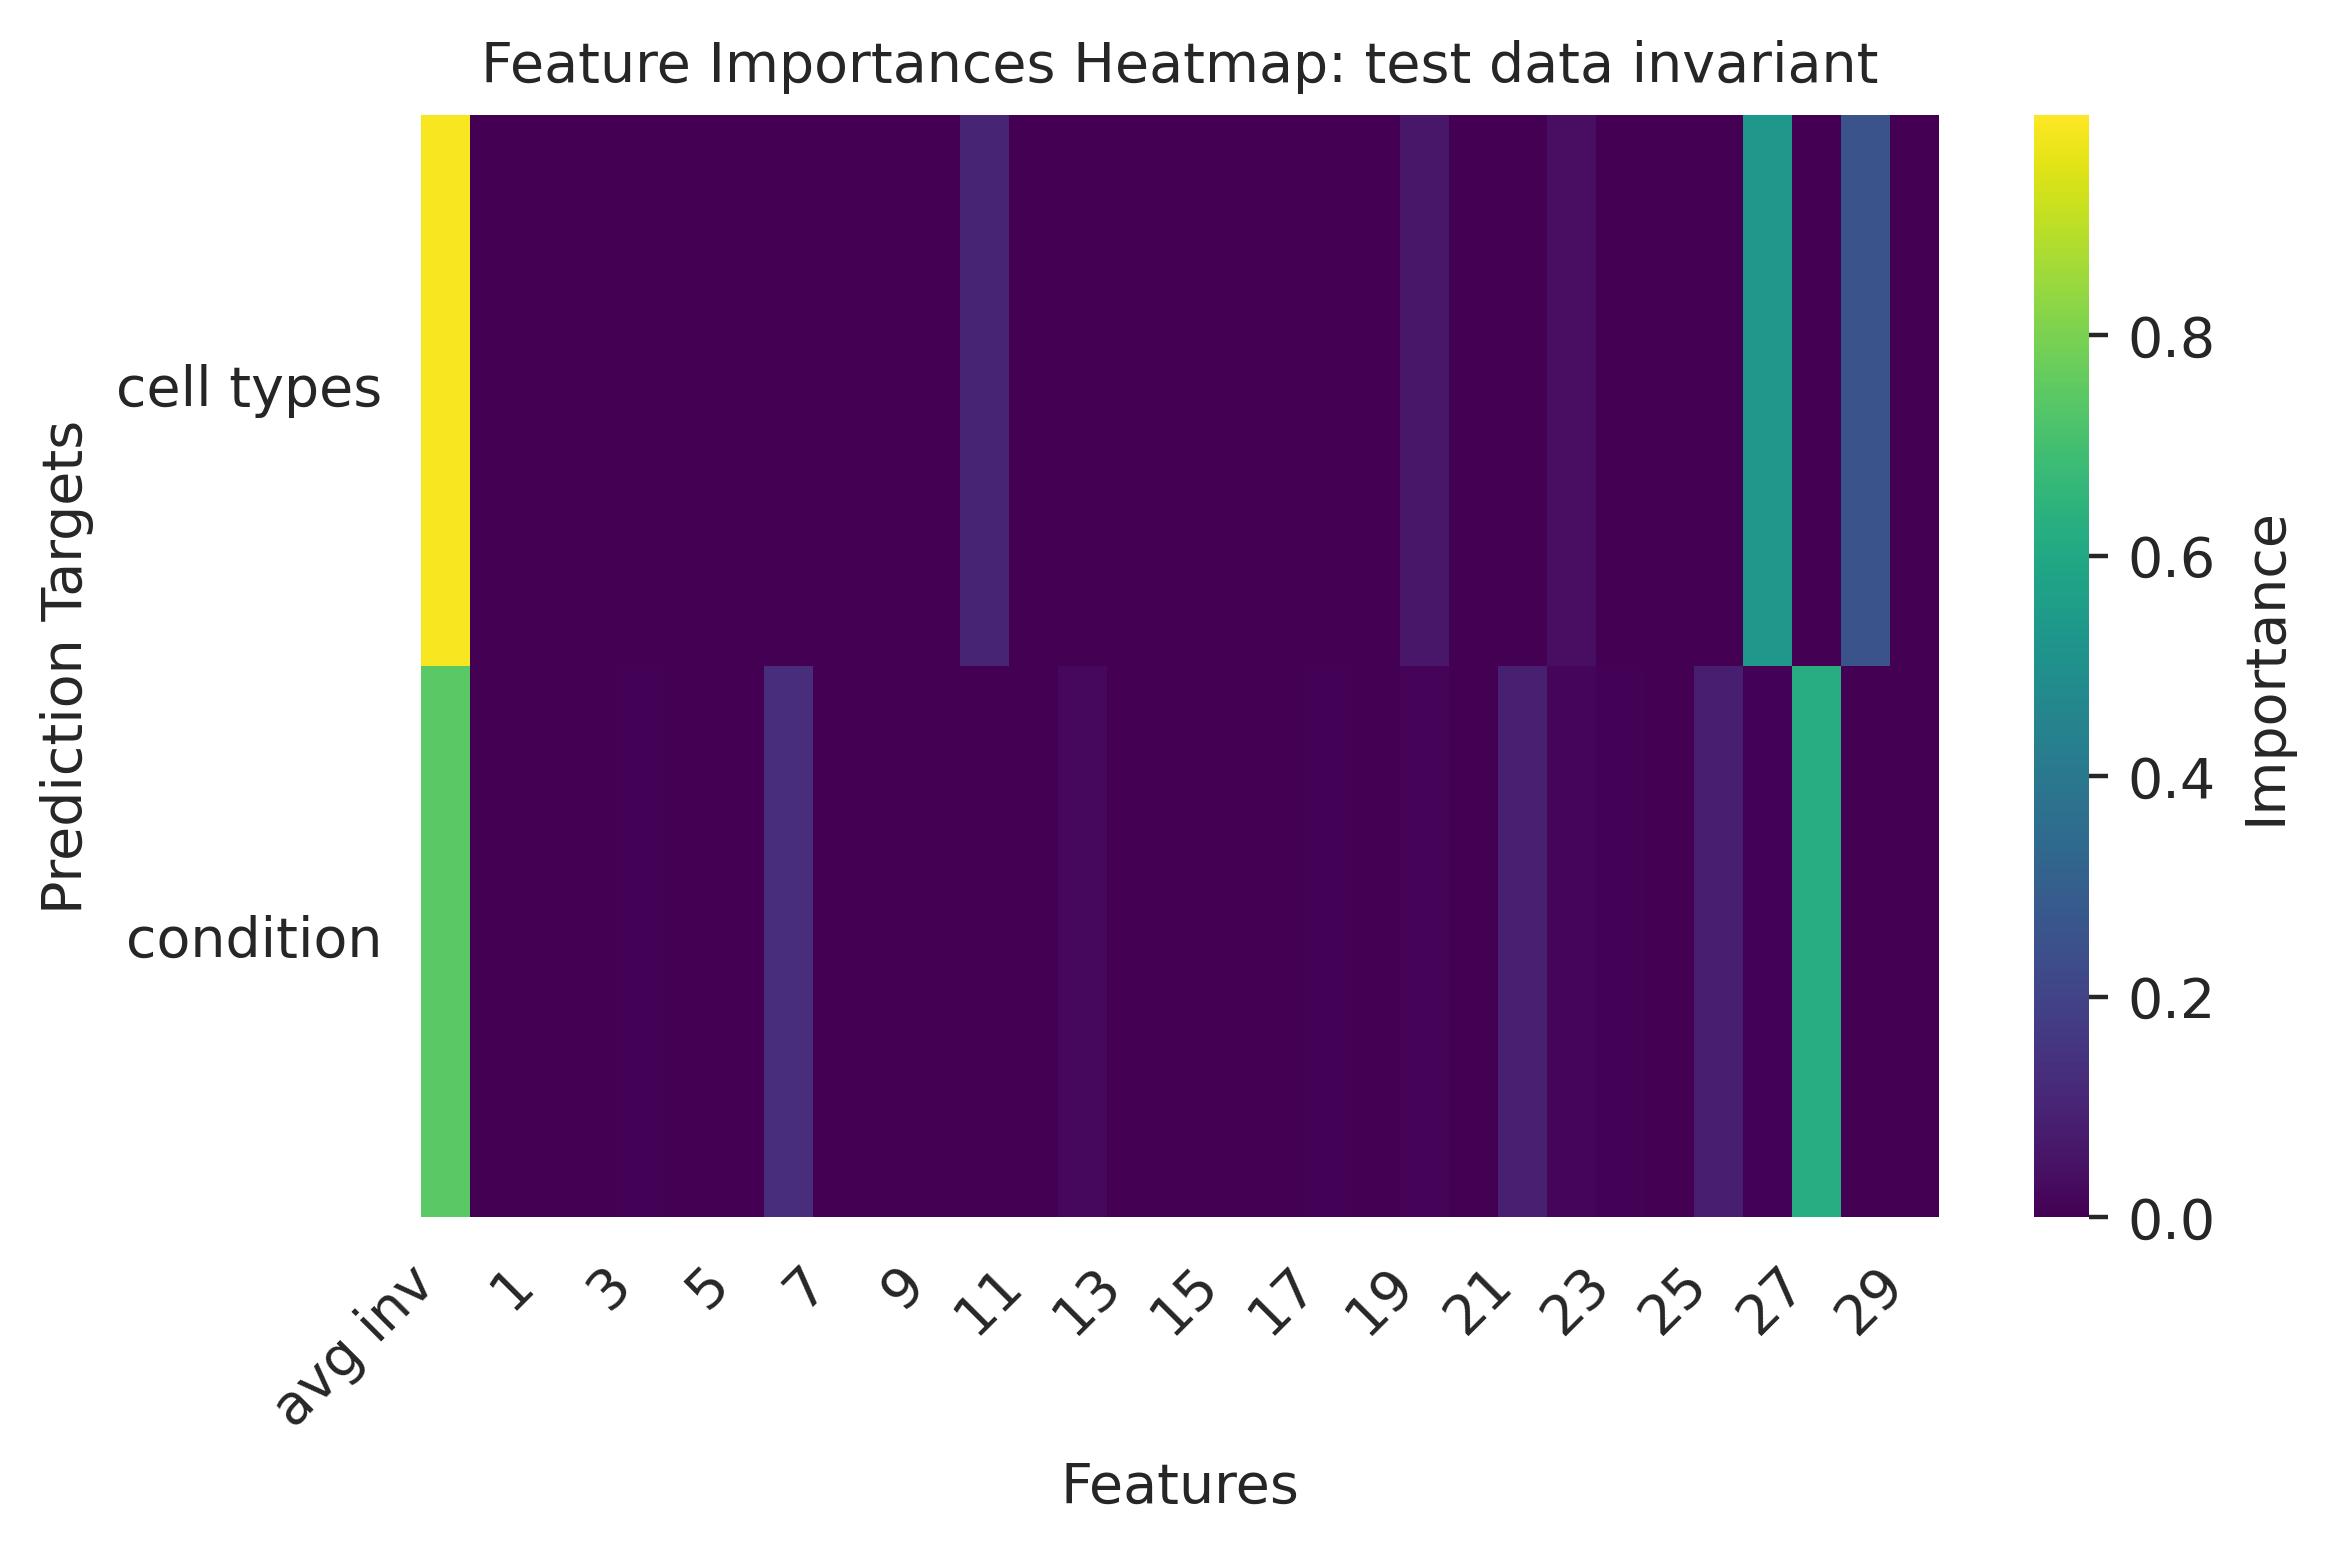

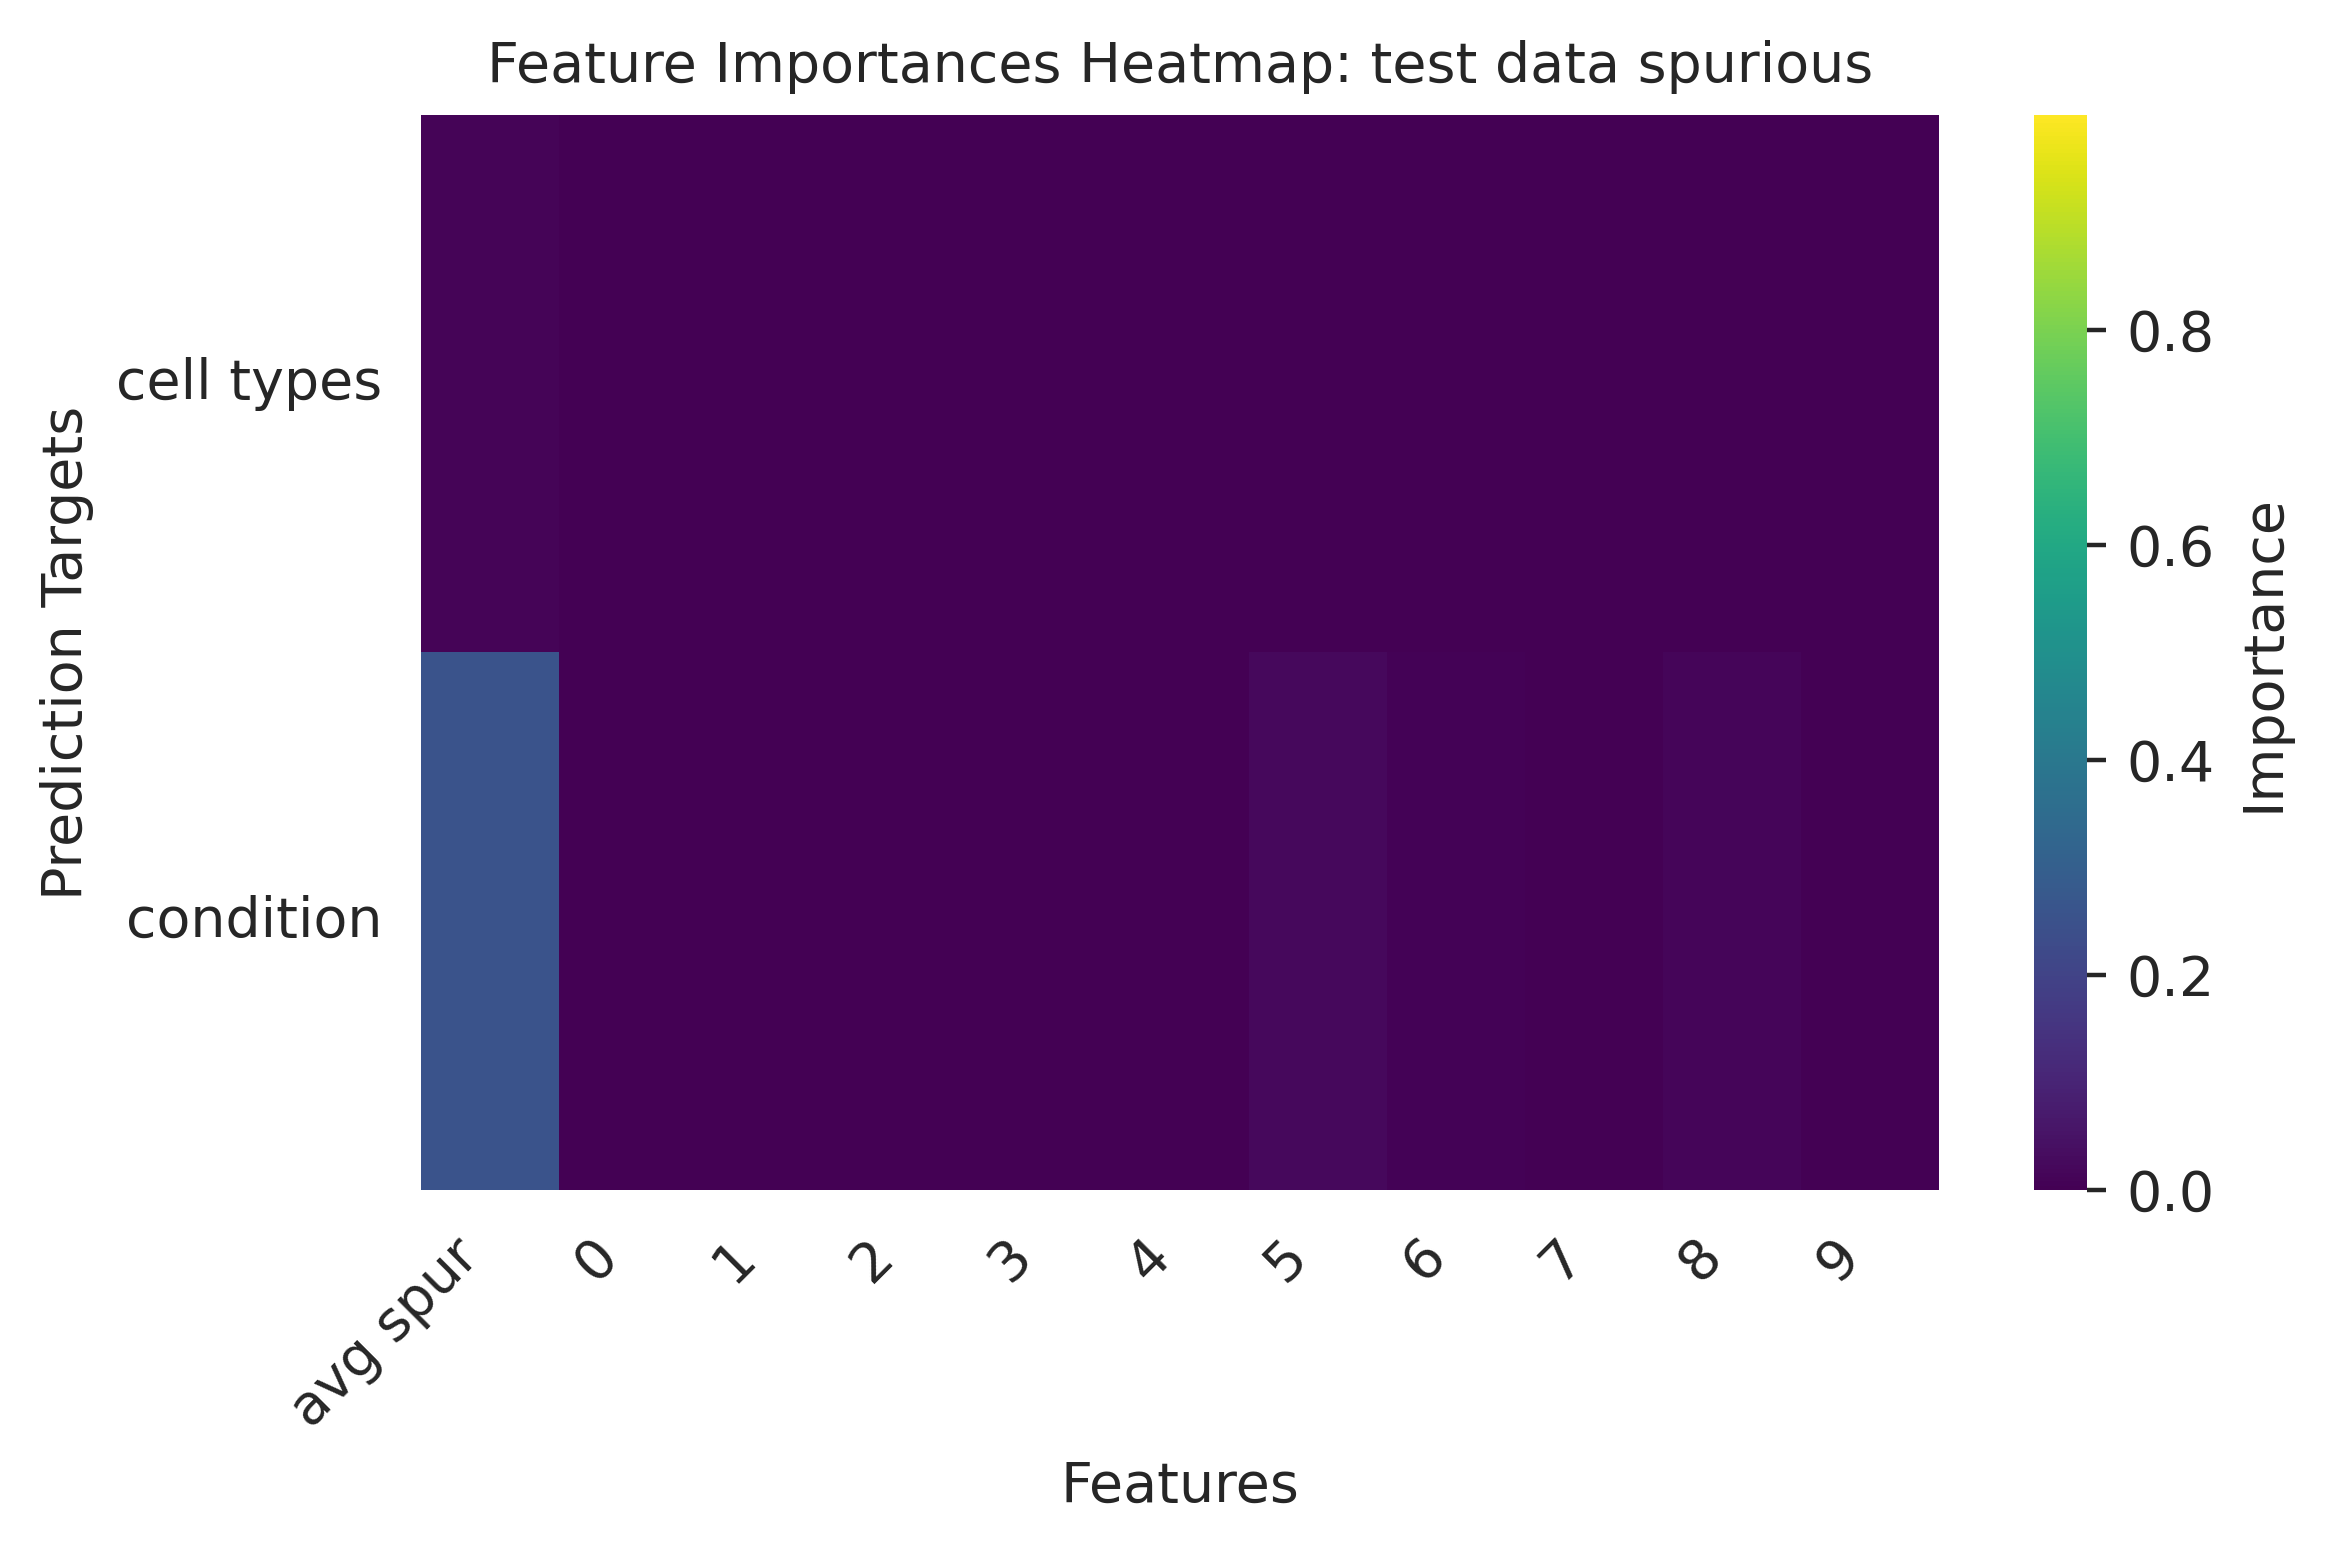

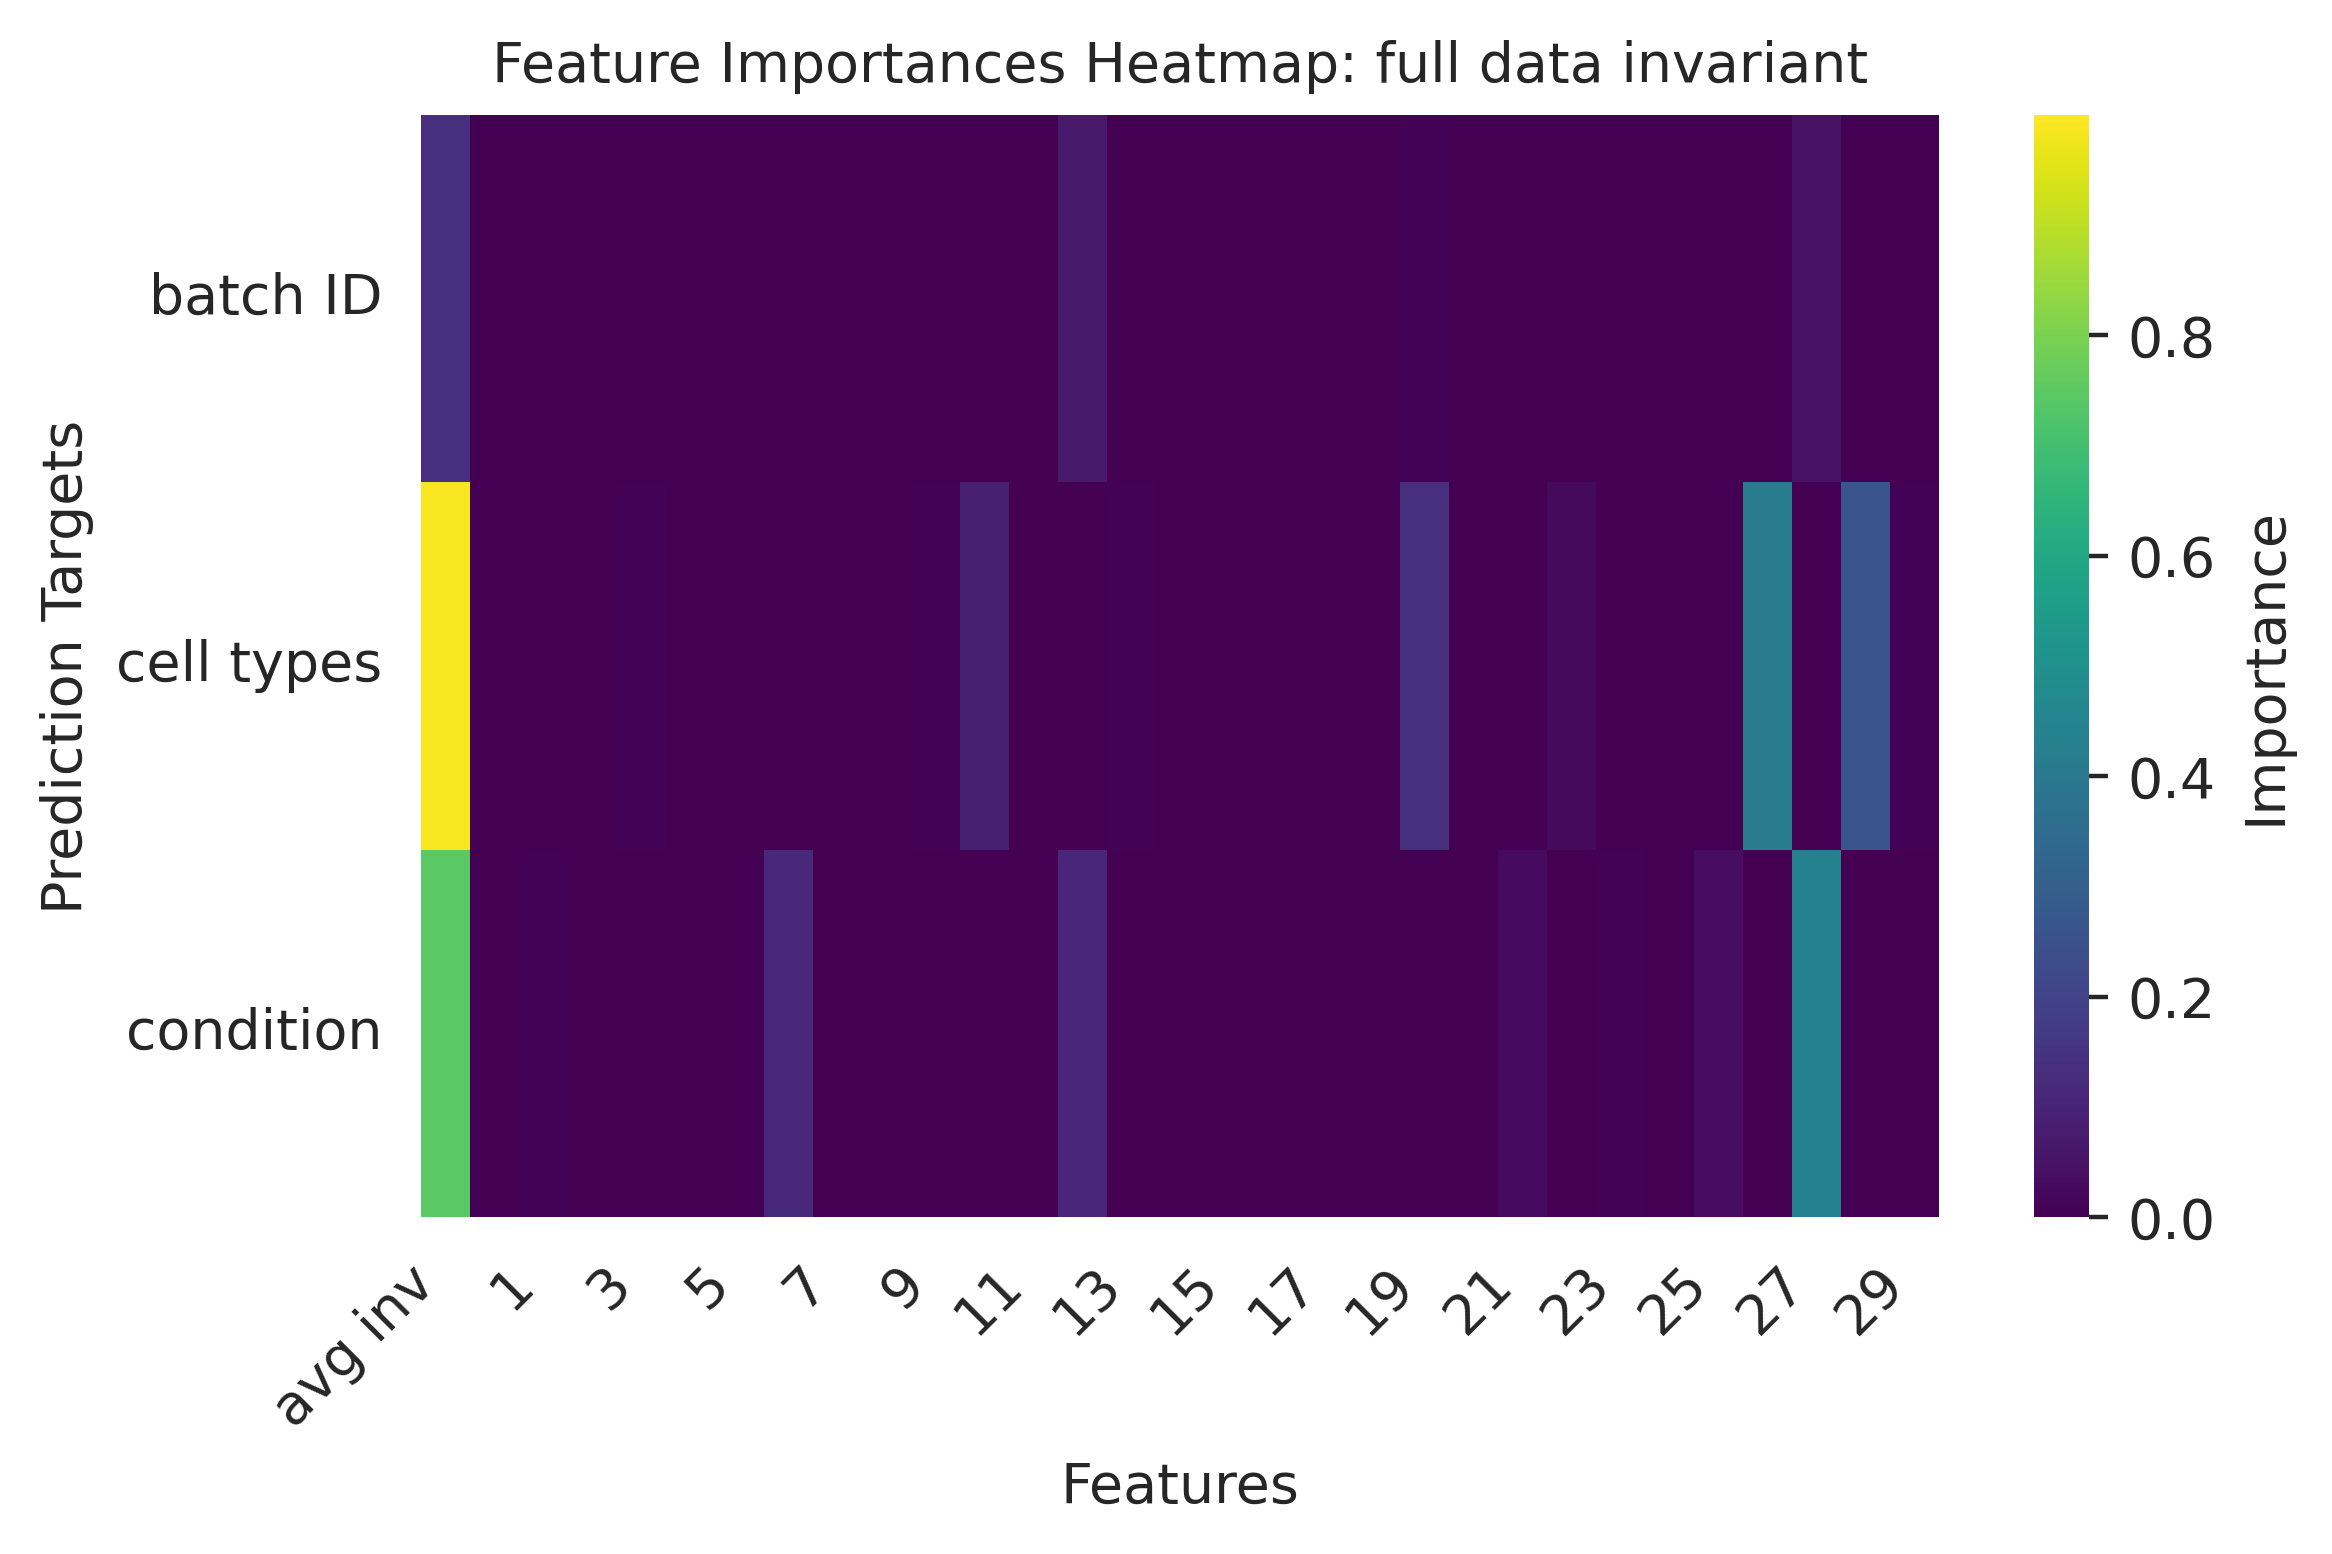

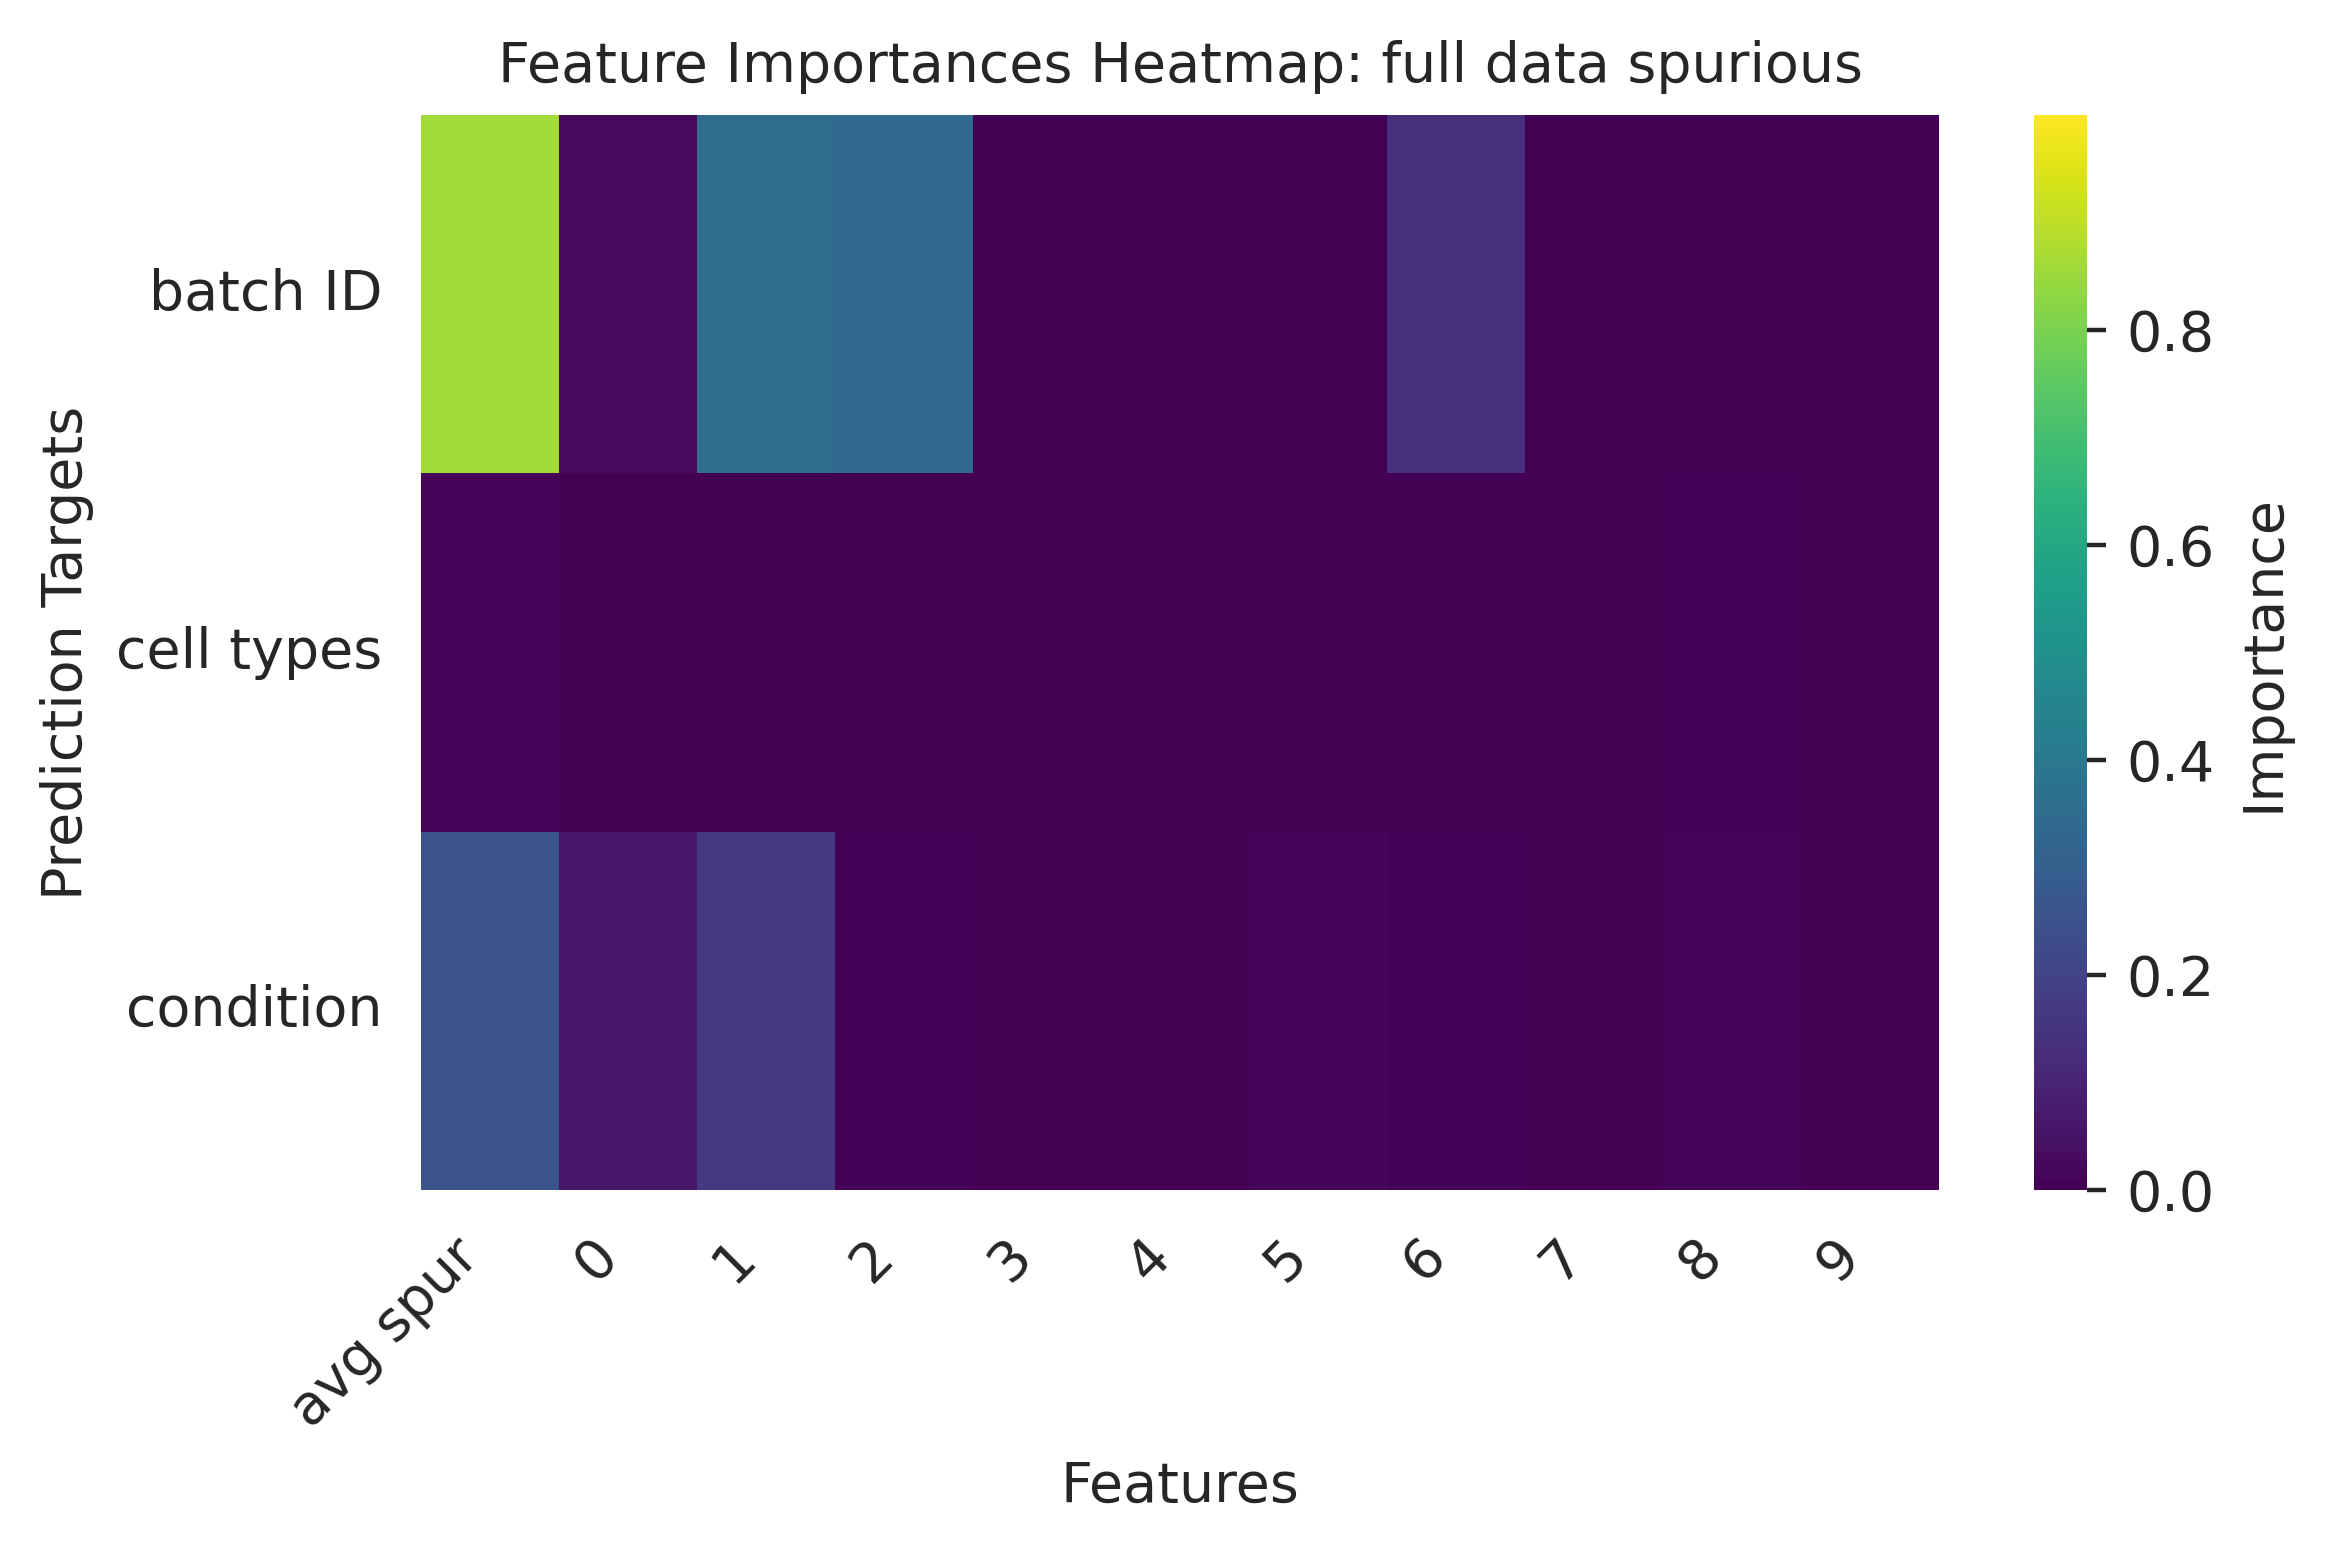

In [118]:
plot_output_dir = '/home/icb/ferdinand.kapl/project-inpossible/outputs/experiments/disentanglement'

full_feature_imp_test = pd.read_csv('/home/icb/ferdinand.kapl/project-inpossible/outputs/experiments/disentanglement/feature_importances_test.csv', index_col=0)
full_feature_imp_df = pd.read_csv('/home/icb/ferdinand.kapl/project-inpossible/outputs/experiments/disentanglement/feature_importances.csv', index_col=0)

plot_full_feature = full_feature_imp_df.drop(columns='pred_key')[
    full_feature_imp_df.index.isin(['batch_key_perm', 'predicted_labels_perm', 'condition_perm'])
].rename(
    index={'batch_key_perm': 'batch ID', 'predicted_labels_perm': 'cell types', 'condition_perm': 'condition'}
)

plot_test_feature = full_feature_imp_test.drop(columns='pred_key.1')[
    full_feature_imp_test.index.isin(['predicted_labels_perm', 'condition_perm'])
].rename(
    index={'predicted_labels_perm': 'cell types', 'condition_perm': 'condition'}
)

plot_list = {
    'test': plot_test_feature,
    'full': plot_full_feature
}

#plot_list.append

for name, plot_df in plot_list.items():
    #full_feature_imp_df.index = full_feature_imp_df['pred_key']
    #plot_df = full_feature_imp_df.drop(columns='pred_key')[full_feature_imp_df.index.isin(['batch_key_perm', 'predicted_labels_perm', 'condition_perm'])]
    #plot_df = tmp_df.drop(columns='pred_key') #full_feature_imp_HGBT.drop(columns='pred_key')
    #plot_df = tmp_perm_df.drop(columns='pred_key')

    # Set the figure size
    #plt.figure(figsize=(8, 6))
    avg_inv = plot_full_feature.iloc[:,:30].sum(axis=1)
    avg_spur = plot_full_feature.iloc[:,30:].sum(axis=1)

    plot_df['avg inv'] = avg_inv
    plot_df['avg spur'] = avg_spur

    # Reorder columns
    col_order_inv = ['avg inv'] + [f'invariant{i}' for i in range(30)]
    col_order_spur = ['avg spur'] + [f'spurious{i}' for i in range(10)]
    plot_df_inv = plot_df[col_order_inv].rename(columns={f'invariant{i}': f'{i}' for i in range(30)})
    plot_df_spur = plot_df[col_order_spur].rename(columns={f'spurious{i}': f'{i}' for i in range(10)})
    # Create the heatmap
    sns.set_style({'axes.grid' : True})
    sns.heatmap(plot_df_inv, annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'Importance',  'ticks': [0, 0.2, 0.4, 0.6, 0.8]}, vmin=0, vmax=1)

    # Add labels and title
    plt.xlabel('Features')
    plt.ylabel('Prediction Targets')
    plt.title(f'Feature Importances Heatmap: {name} data invariant')
    

    # Rotate x-axis labels if necessary
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0, ha='right')

    # Adjust layout
    plt.tight_layout()
    plt.savefig(os.path.join(plot_output_dir, f'heatmap_{name}_data_invariant.pdf'), format='pdf')
    # Show the plot
    plt.show()

    # Create the heatmap
    sns.heatmap(plot_df_spur, annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'Importance',  'ticks': [0, 0.2, 0.4, 0.6, 0.8]}, vmin=0, vmax=1)

    # Add labels and title
    plt.xlabel('Features')
    plt.ylabel('Prediction Targets')
    plt.title(f'Feature Importances Heatmap: {name} data spurious')

    # Rotate x-axis labels if necessary
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0, ha='right')

    # Adjust layout
    plt.tight_layout()
    plt.savefig(os.path.join(plot_output_dir, f'heatmap_{name}_data_spurious.pdf'), format='pdf')
    # Show the plot
    plt.show()


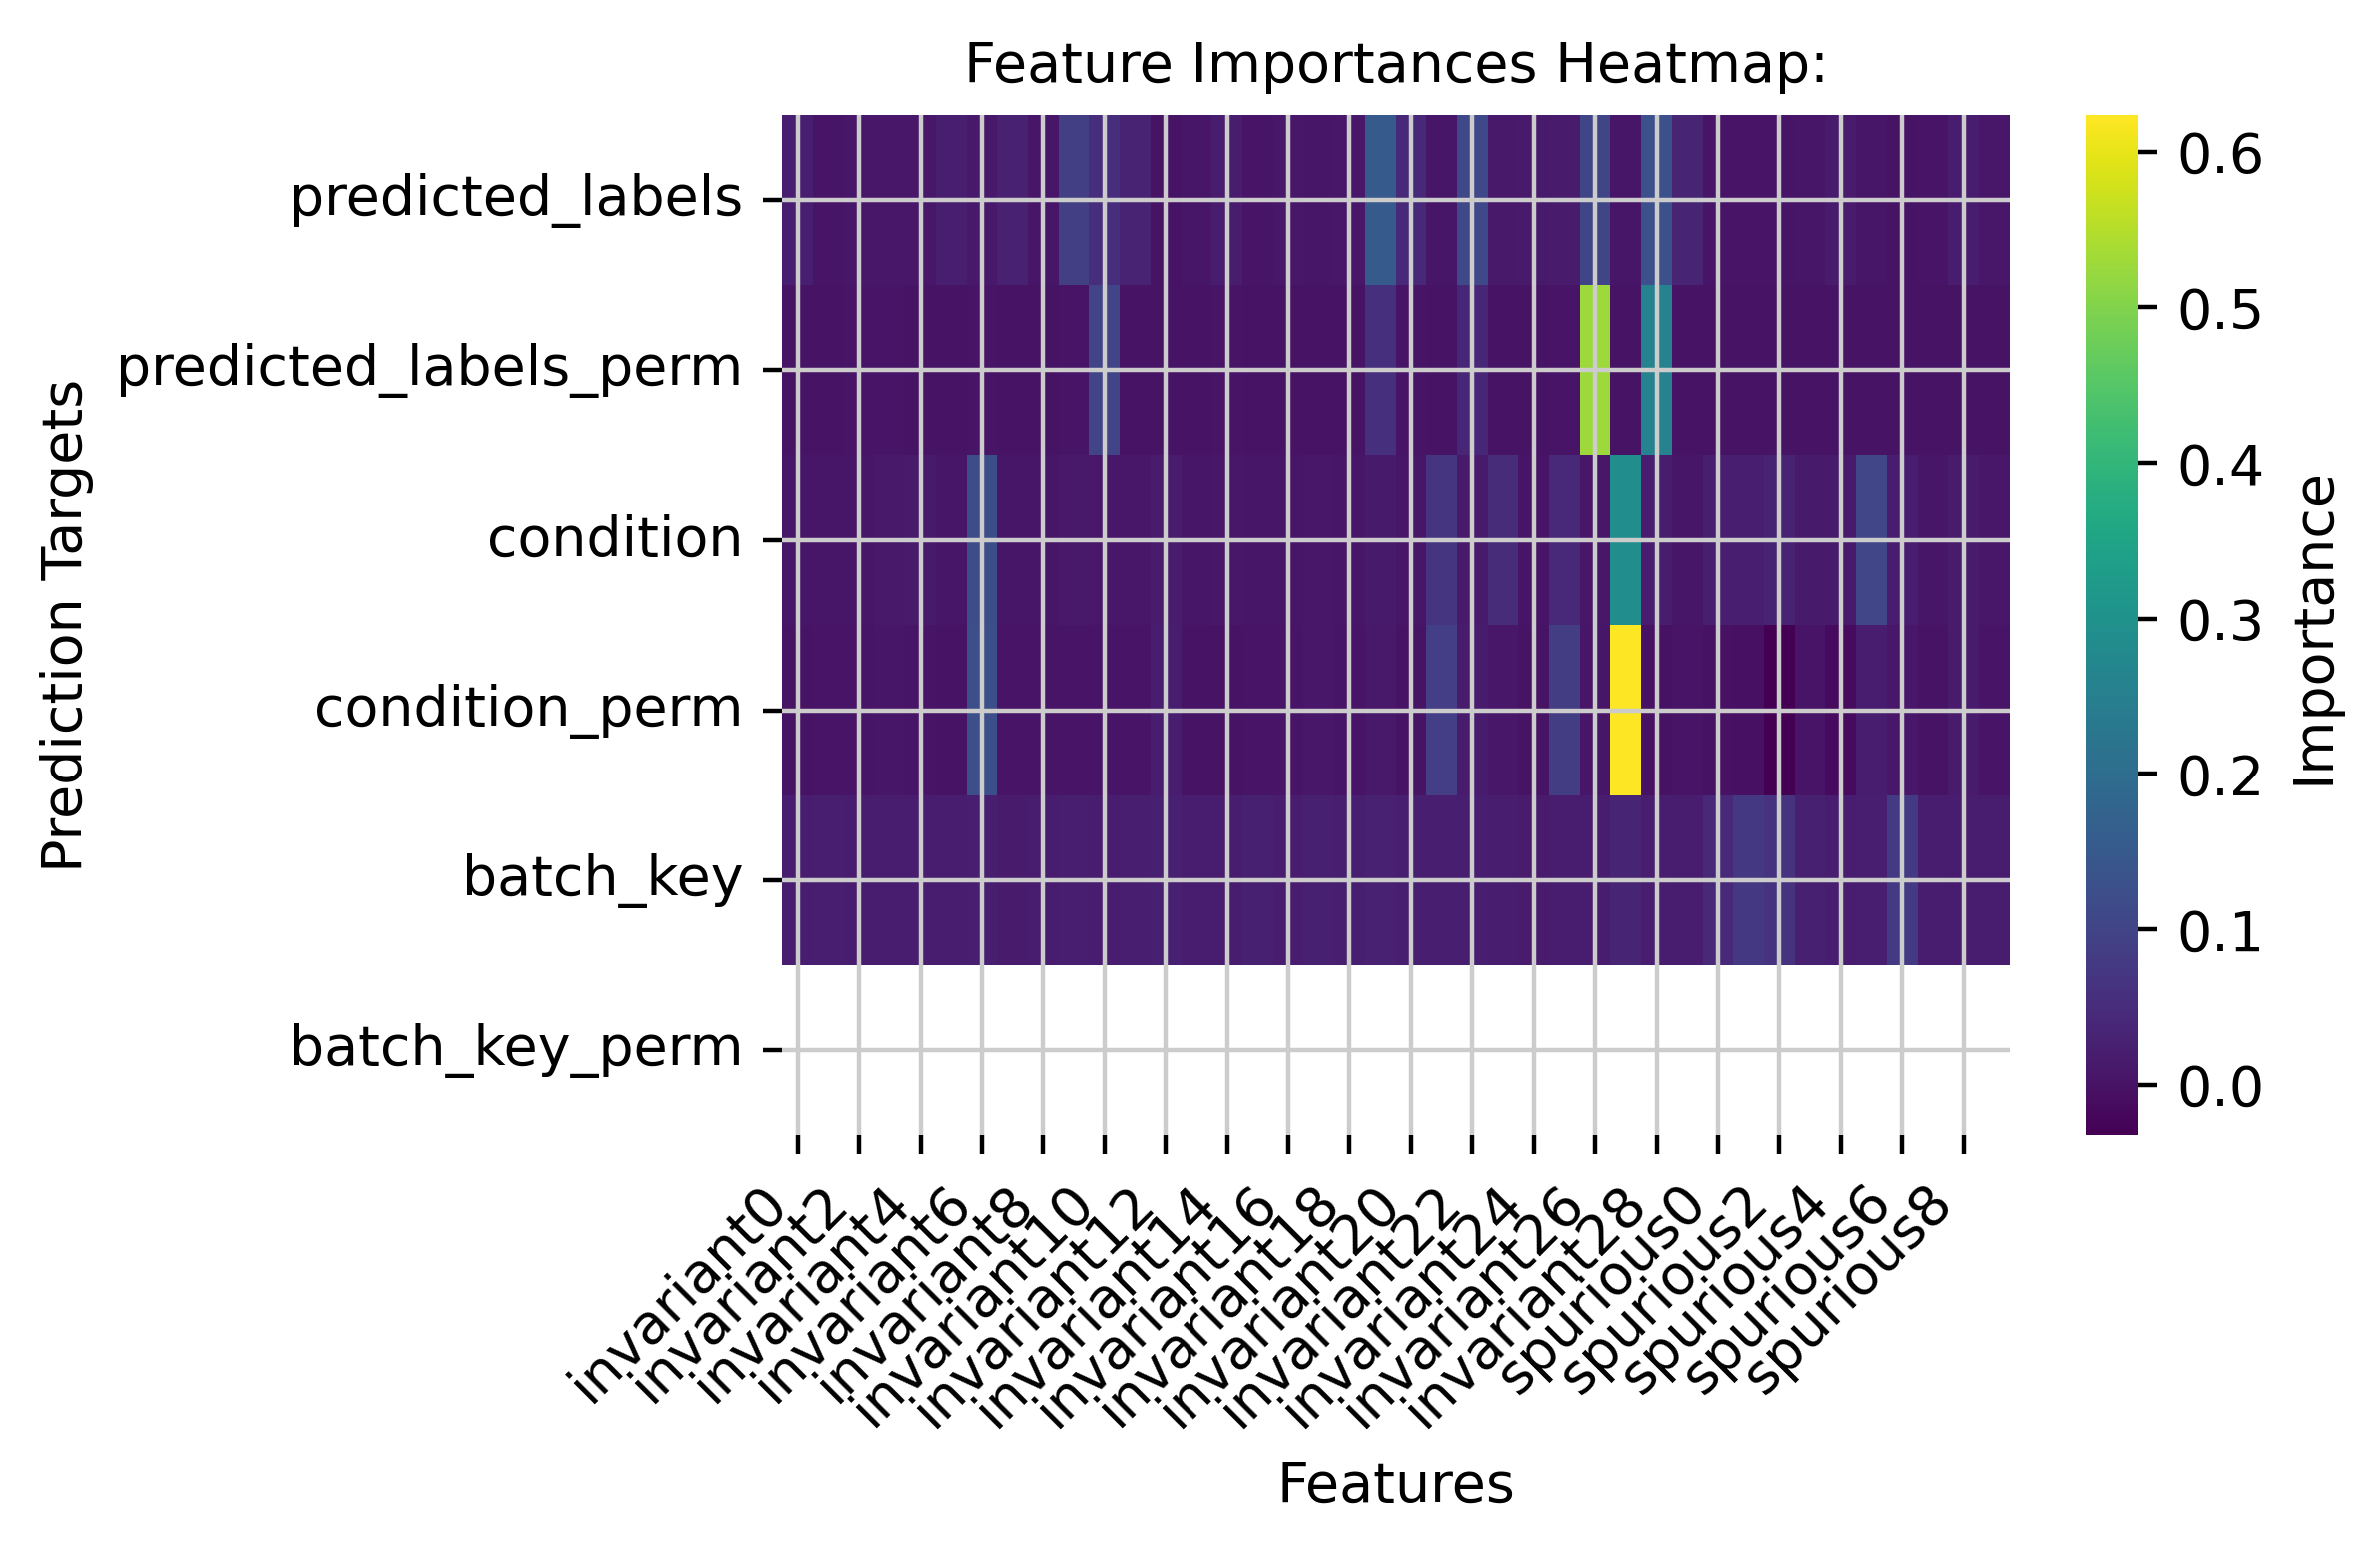

In [59]:
#full_feature_imp_df.index = full_feature_imp_df['pred_key']
#plot_df = full_feature_imp_df.drop(columns='pred_key')[full_feature_imp_df.index.isin(['batch_key_perm', 'predicted_labels_perm', 'condition_perm'])]
plot_df = tmp_df.drop(columns='pred_key') #full_feature_imp_HGBT.drop(columns='pred_key')
#plot_df = tmp_perm_df.drop(columns='pred_key')

# Set the figure size
#plt.figure(figsize=(8, 6))

# Create the heatmap
sns.heatmap(plot_df, annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'Importance'})

# Add labels and title
plt.xlabel('Features')
plt.ylabel('Prediction Targets')
plt.title('Feature Importances Heatmap:')

# Rotate x-axis labels if necessary
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
